# Library

In [1]:
import math
import random
import squigglepy as sq
from squigglepy import bayes
from squigglepy.numbers import K, M, B, T

import numpy as np
import matplotlib.pyplot as plt

from copy import deepcopy
from scipy import stats
from pprint import pprint
from collections import Counter
%matplotlib inline
print('Loaded 1')


exec(open('library.py').read())
print('Loaded 2')


STATES = ['boring', 'xrisk_tai_misuse', 'aligned_tai', 'xrisk_full_unaligned_tai_extinction',
          'xrisk_full_unaligned_tai_singleton', 'xrisk_subtly_unaligned_tai', 'xrisk_unknown_unknown',
          'xrisk_nanotech', 'xrisk_nukes_war', 'xrisk_nukes_accident', 'xrisk_bio_accident', 'xrisk_bio_war',
          'xrisk_bio_nonstate', 'xrisk_supervolcano']

extinctions = ['xrisk_full_unaligned_tai_extinction', 'xrisk_nukes_war', 'xrisk_nukes_accident',
               'xrisk_unknown_unknown', 'xrisk_nanotech', 'xrisk_bio_accident', 'xrisk_bio_war',
               'xrisk_bio_nonstate', 'xrisk_supervolcano']


def print_states(states):
    c = Counter(states)
    c = dict([(k, round(v / RUNS * 100, 2)) for k, v in c.items()])
    for k in c.keys():
        if k not in STATES:
            raise ValueError('State {} not in `STATES`'.format(k))
    for state in STATES:
        if not c.get(state):
            c[state] = 0.0
    c = sorted(c.items(), key=lambda x: x[1], reverse=True)
    return c

print('Loaded 3')


Loaded 1
Loaded 2
Loaded 3


# Variables (customize these)

In [2]:
# Customize these!!!

# Global variables - probably don't want to change these but you could.
RUNS = 10*K                                       # Number of runs to do (default 1000)
CURRENT_YEAR = 2022                               # What year to start the run on? (default: 2022)
MAX_YEAR = 2222                                   # What year to end the run on? (default: 2100)

print('Loaded')



Loaded


In [3]:
## AI TIMELINE VARIABLES

def sample_tai_log_flop_needs(brain, efficiency, transformative_vs_human, horizon_length, scaling_exponent,
                              flops_per_param_per_sec, params=None, ref_params=11.2, ref_params_samples=12,
                              bayes_update=None, debug=False):
    # Debug = 1 for just printing parameters
    # Debug = 2 for just printing the equation
    # Debug = True or debug = 3 for printing both
    
    if bayes_update is None:
        bayes_update = lambda x: x
    
    brain_ = sq.sample(brain)
    eff_ = sq.sample(efficiency)
    tvh_ = sq.sample(transformative_vs_human)
    h_ = sq.sample(horizon_length)
    e_ = sq.sample(scaling_exponent)
    fpp_ = sq.sample(flops_per_param_per_sec)
    
    if debug is True or debug == 1 or debug == 2 or debug == 3:
        print('Anchor debug:')
        
    if debug is True or debug == 1 or debug == 3:
        print('-- Assume human brain in inference takes {} log FLOP'.format(round(brain_, 1)))
        print('-- Add {} log FLOP for efficiency'.format(round(eff_, 1)))
        print('-- Assume a transformative model takes {} log FLOP compared to human'.format(round(tvh_, 1)))
        print('-- Assume a horizon length of {}'.format(round(h_, 1)))
        print('-- Assume a scaling exponent of {}'.format(round(e_, 3)))
        print('-- Assume FLOPs per param per sec of {}'.format(round(fpp_, 1)))
    
    if params is None:
        params_ = brain_ + eff_ - fpp_        
    else:
        params_ = sq.sample(params)
    
    out = brain_ + eff_ + tvh_ + h_ + ref_params_samples - e_ * ref_params + e_ * params_
    
    if debug is True or debug == 2 or debug == 3:
        if params is None:
            print(f"-- {round(out, 1)} = {round(brain_, 1)} + {round(eff_, 1)} + {round(tvh_, 1)} + {round(h_, 1)} + {ref_params_samples} - {round(e_, 3)} * {ref_params} + {round(e_, 3)} * ({round(brain_, 1)} + {round(eff_, 1)} - {round(fpp_, 1)})")
        else:
            print(f"-- {round(out, 1)} = {round(brain_, 1)} + {round(eff_, 1)} + {round(tvh_, 1)} + {round(h_, 1)} + {ref_params_samples} - {round(e_, 3)} * {ref_params} + {round(e_, 3)} * {round(params_, 2)}")
    
    out = bayes_update(out)
    if debug is True or debug == 2 or debug == 3:
        print('-- {} after Bayes update'.format(round(out, 1)))
    if debug is True or debug == 1 or debug == 2 or debug == 3:
        print('-')

    return out


def wildeford_bayes_update_against_low_flop(f):
    f = f + sq.sample(sq.norm(1,3)) if f < 27 and sq.event_occurs(p=0.1) else f
    f = f + sq.sample(sq.norm(1,3)) if f < 26 and sq.event_occurs(p=0.2) else f
    f = f + sq.sample(sq.norm(1,3)) if f < 25 and sq.event_occurs(p=0.6) else f
    f = f + sq.sample(sq.norm(1,3)) if f < 24 and sq.event_occurs(p=0.8) else f
    return f


def wildeford_meta_anchor(efficiency, debug=False):
    horizon_length = sq.mixture([[0.4, sq.const(0)],
                                 [0.2, sq.norm(0,3)],
                                 [0.25, sq.lognorm(3,7)],
                                 [0.15, sq.norm(7,11)]],
                                lclip=0)
    
    return sample_tai_log_flop_needs(brain=sq.lognorm(11,19.5),
                                     efficiency=efficiency,
                                     transformative_vs_human=sq.norm(-2,1),
                                     horizon_length=horizon_length,
                                     scaling_exponent=sq.norm(0.5,1.5),
                                     flops_per_param_per_sec=sq.norm(1,2),
                                     bayes_update=wildeford_bayes_update_against_low_flop,
                                     debug=debug)


def wildeford_max_gdp_frac():
    small_project = sq.lognorm(1 / (250*K), 1 / (3*K))
    modern_megaproject = sq.lognorm(1/K, 1/600)
    old_form_megaproject = sq.lognorm(1/500, 1/150)
    gigaproject = sq.lognorm(1/150, 1/50)
    
    r_ = random.random()
    if r_ < 0.1:
        gdp_frac = small_project
        percent_spent_on_compute = sq.lognorm(0.2,0.6, lclip=0.1, rclip=0.9)
    elif r_ < 0.8:
        gdp_frac = modern_megaproject
        percent_spent_on_compute = sq.lognorm(0.4,0.7, lclip=0.1, rclip=0.9)
    elif r_ < 0.95:
        gdp_frac = old_form_megaproject
        percent_spent_on_compute = sq.lognorm(0.5,0.9, lclip=0.1, rclip=0.9)
    else:
        gdp_frac = gigaproject
        percent_spent_on_compute = sq.lognorm(0.6,0.9, lclip=0.1, rclip=0.9)

    return sq.sample(gdp_frac) * sq.sample(percent_spent_on_compute)


initial_gdp = 21.3*T

initial_flops_per_dollar = sq.const(18)

tai_flop_size = wildeford_meta_anchor

flops_halving_rate = sq.lognorm(2, 5)

initial_pay = sq.mixture([[0.8, sq.const(7.1)],
                          [0.2, sq.lognorm(7.1,9, lclip=7.1)]])

max_flops_per_dollar = sq.const(24)

gdp_growth = sq.lognorm(1.015, 1.035) #NEW

max_gdp_frac = wildeford_max_gdp_frac #NEW

spend_doubling_time = sq.mixture([[0.8, sq.lognorm(3,6)],
                                  [0.2, sq.lognorm(1,2, lclip=1)]])
# TODO: Willingness to spend connected to commercialization

initial_chance_of_nonscaling_issue = 0.9
final_chance_of_nonscaling_issue = 0.2 #NEW
nonscaling_issue_bottom_year = 2040
nonscaling_delay = sq.mixture([[0.7, sq.lognorm(2,10)],
                               [0.3, sq.lognorm(2,35)]]) #NEW

algo_doubling_rate_max = sq.norm(1,3) # NEW
algo_doubling_rate_min = sq.norm(1,2) # NEW

efficiency = sq.mixture([[0.1, sq.const(0)],
                          [0.9, sq.lognorm(1,4)]])

use_efficiency_based_algo_reduction = True
efficiency_based_additional_reduction = sq.mixture([[0.4, sq.const(0)],
                                                    [0.6, sq.norm(0,2)]]) # NEW

p_willingness_ramp = 0

willingness_spend_horizon = sq.const(1)

# These equations define how variables change over time or in relationship to other variables.
def gdp(initial_gdp, gdp_growth, year):
    return initial_gdp * (gdp_growth ** year)


def willingness_to_pay(initial_gdp, gdp_growth, initial_pay, spend_doubling_time, max_gdp_frac, year):
    gdp_ = gdp(initial_gdp=initial_gdp, gdp_growth=gdp_growth, year=year)
    x = (np.log(2) / spend_doubling_time) * year
    if x < 700:
        y = math.log10(initial_pay) + math.log10(math.exp(x)) - math.log10(1 + initial_pay / (gdp_ * max_gdp_frac) * math.exp(x))
        if y > 300:
            y = int(y) # Handle overflow errors
        return 10 ** y
    else: # Handle math.exp and math.log10 overflow errors
        return 10 ** int(math.log10(initial_pay) + (year/spend_doubling_time)/3.3)
    

def algo_halving_fn(min_speed, max_speed, tai_flop_size):
    if max_speed < min_speed:
        max_speed = min_speed
    if min_speed > max_speed:
        min_speed = max_speed
    return min(max(max_speed - (round((tai_flop_size - 29) / 2) / 2), min_speed), max_speed)


def flops_needed(initial_flops, possible_reduction, doubling_rate, year):
    x = (np.log(2) / doubling_rate) * year
    if x < 700:
        y = (math.log10(initial_flops) - max(math.log10(math.exp(x)) - math.log10(1 + (1/possible_reduction) * math.exp(x)), 0))
        if y > 300:
            y = int(y) # Handle overflow errors        
        return 10 ** y
    else: # Handle math.exp and math.log10 overflow errors
        return 10 ** int(math.log10(initial_flops) - (1/possible_reduction))

    
def flops_per_dollar(initial_flops_per_dollar, max_flops_per_dollar, halving_rate, year):
    x = (np.log(2) / halving_rate) * year
    if x < 700:
        y = (math.log10(initial_flops_per_dollar) + math.log10(math.exp(x)) - math.log10(1 + initial_flops_per_dollar / max_flops_per_dollar * math.exp(x)))
        if y > 300:
            y = int(y) # Handle overflow errors                
        return 10 ** y
    else: # Handle math.exp and math.log10 overflow errors
        return 10 ** int(math.log10(initial_flops_per_dollar) + (year/halving_rate)/3.3)

    
def cost_of_tai(initial_flops, possible_reduction, algo_doubling_rate, initial_flops_per_dollar, max_flops_per_dollar,
                flops_halving_rate, year):
    return (flops_needed(initial_flops, possible_reduction, algo_doubling_rate, year) /
            flops_per_dollar(initial_flops_per_dollar, max_flops_per_dollar, flops_halving_rate, year))


def flops_at_max(initial_gdp, gdp_growth, initial_pay, spend_doubling_time, max_gdp_frac,
                 initial_flops_per_dollar, max_flops_per_dollar, flops_halving_rate, year):
    return (willingness_to_pay(initial_gdp=initial_gdp,
                               gdp_growth=gdp_growth,
                               initial_pay=initial_pay,
                               spend_doubling_time=spend_doubling_time,
                               max_gdp_frac=0.01,
                               year=year) *
            flops_per_dollar(initial_flops_per_dollar, max_flops_per_dollar, flops_halving_rate, year))


def possible_algo_reduction_fn(min_reduction, max_reduction, tai_flop_size):
    if max_reduction < min_reduction:
        max_reduction = min_reduction
    if min_reduction > max_reduction:
        min_reduction = max_reduction
    return min(max(min_reduction + round((tai_flop_size - 32) / 4), min_reduction), max_reduction)


# NEW
def p_nonscaling_delay(initial_p, final_p, year, max_year):
    return generalized_logistic_curve(x=year - CURRENT_YEAR,
                                      slope=0.3,
                                      shift=3 * (max_year - CURRENT_YEAR),
                                      push=1,
                                      maximum=final_p,
                                      minimum=initial_p)


print('Loaded')


Loaded


In [4]:
### AI SCENARIO VARIABLES

# Conditoinal on making TAI, will it be agentic?
p_make_agent_tai = 0.9

# Conditional on making agentic TAI, will it be aligned by default?
p_tai_aligned_by_default = 0.1

# Conditional on making agentic TAI that is not aligned by default, will we solve the alignment problem?
# Varies by year, whether this is the first attempt, and whether there is a great power war
def p_alignment_solved(war, year, first_attempt=True, verbose=False):
    if first_attempt:
        p = min(0.05 + 1.1 * (year/45), 0.7)
    else:
        p = min(0.05 + 1.4 * (year/45), 0.8)
    if war:
        p = p * 0.5
    if verbose == 2:
        print('* alignment diagnostic - war: {} year: {} first attempt: {} -> p {})'.format(war, year, first_attempt, p))
    return p
# TODO: Convert to logistic curves

# Conditional on solving the alignment problem, what is the chance we also solve the subtle misalignment problem?
p_subtle_alignment_solved = 0.85

# Conditional on alignment by default, what is the chance we also solve the subtle misalignment problem?
p_subtle_alignment_solved_if_aligned_by_default = 0.65

# Conditional on having agentic TAI, will it be intentionally misused to create a singleton?
def p_tai_intentional_misuse(war):
    return 0.3 if war else 0.05

# If TAI is fully misaligned what is the chance we can successfully detect and avert this?
p_full_tai_misalignment_averted = 0.1

# If TAI is fully misaligned but successfully averted, what is the probability there will be a catasrophe (10%+ death)?
p_tai_misalignment_averting_is_catastrophic = 0.3

# If TAI is fully misaligned and we successfully avert it, what is the chance we give up on TAI?
p_full_tai_misalignment_averted_means_abandoned_tai = 0.7

# If TAI is fully misaligned, what is the chance it results in extinction versus a singleton?
p_tai_xrisk_is_extinction = 0.35

# If there is a fully misaligned TAI singleton, what is the chance it results in a non-extinction catastrophe (10%+ death)?
p_tai_singleton_is_catastrophic = 0.8


print('Loaded')


Loaded


In [5]:
### GREAT POWER WAR VARIABLES

# What is the chance in a given year there will be a great power war?
def p_great_power_war(year):
    if year < 2025:
        return 0.003 + (1-0.003)*0.005
    elif year < 2030:
        return 0.004 + (1-0.004)*0.3/5 + (1-0.004)*(1-0.3/5)*0.3*0.01*0.2
    elif year < 2040:
        return 0.005 + (1-0.005)*0.7/5 + (1-0.005)*(1-0.7/5)*0.05*0.01*0.2
    else:
        return (0.006 + (1-0.006)*(1-0.7/5)*0.05*0.01*0.2) * (0.95 ** year)

# Conditional on a great power war starting, how long will it last?
war_length = sq.lognorm(2, 50) # 90% CI

# TODO: There should be a small chance of catastrophe and x-risk from great power war, absent nuclear or bio pathway
# TODO: There should be a chance of nukes-related catastrophe and x-risk from breaking nuclear symmetry


print('Loaded')


Loaded


In [6]:
### NUCLEAR WAR VARIABLES

# What is the chance in a given year there will be a "nuclear accident"?
def p_nuclear_accident(war, year):
    p = 0.06 if war else 0.02
    p = p * (0.998 ** year)
    return p
# TODO: Graph


# Conditional on a nuclear accident, what is the chance it escalates into an "exchange"?
def p_nuclear_accident_becomes_exchange(war):
    return 0.4 if war else 0.2


# Conditional on a nuclear exchange, what is the chance it escalates into a catastrophe (10%+ dead)?
def p_catastrophe_from_nuclear_exchange(war):
    p_exchange_becomes_all_out_war = 0.3 if war else 0.05
    p_catastrophe_given_all_out_war = 0.8 # https://www.getguesstimate.com/models/14186
    return p_exchange_becomes_all_out_war * p_catastrophe_given_all_out_war
    
    
# Conditional on a nuclear exchange catastrophe, what is the chance it becomes an xrisk?
def p_xrisk_from_nuclear_catastrophe(war):
    return 0.05 * 0.05 # https://www.getguesstimate.com/models/14186 and https://forum.effectivealtruism.org/posts/GsjmufaebreiaivF7/what-is-the-likelihood-that-civilizational-collapse-would


# Conditional on a great power war, what is the chance it goes intentionally nuclear in any given year?
p_nuclear_war_given_war = 0.01


print('Loaded')


Loaded


In [7]:
### BIO RISK VARIABLES

# Conditional on a great power war, what is the annual chance it intentionally results in a bioweapon?
p_biowar_given_war = 1/700

# What is the annual chance of a non-state actor creating an intentional biorisk that causes 1%+ death?
p_nonstate_bio = 1/1000

# What is the chance that if 1%+ die from natural bio, 10%+ will die from natural bio?
p_natural_bio_is_catastrophe = 1 / (10 ** 0.5) # https://www.liebertpub.com/doi/pdfplus/10.1089/hs.2017.0028

# What is the chance that if 1%+ die from engineered bio, 10%+ will die from engineered bio?
p_engineered_bio_is_catastrophe = 1 / (10 ** 0.5) # https://www.liebertpub.com/doi/pdfplus/10.1089/hs.2017.0028

p_covid_spanish_flu_like_becomes_1pct_death = 1 / (10 ** 0.5) # https://www.economist.com/graphic-detail/coronavirus-excess-deaths-estimates suggests COVID killed 0.2%... https://www.liebertpub.com/doi/pdfplus/10.1089/hs.2017.0028 suggests 1% is 2x less likely than 0.2%
p_covid_lab_leak = 0.3
p_extinction_given_99_p_9_pct_death = 0.05 # per Luisa https://forum.effectivealtruism.org/posts/GsjmufaebreiaivF7/what-is-the-likelihood-that-civilizational-collapse-would
p_accidental_catastrophe_causes_99_p_9_pct_death = (1 / (10 ** 0.5)) ** 4 # https://www.liebertpub.com/doi/pdfplus/10.1089/hs.2017.0028
p_intentional_catastrophe_causes_99_p_9_pct_death = (1 / (10 ** 0.5)) ** 3 # https://www.liebertpub.com/doi/pdfplus/10.1089/hs.2017.0028

# If a lab leak occurs, how likely is it that the leaked pandemic will be engineered vs. natural?
ratio_engineered_vs_natural_lab_leak = 0.8

# What is the chance of an natural biorisk/pandemic causing 1%+ population death?
def p_natural_bio(year):
    base_rate_from_covid_and_spanish_flu = 1/500
    decreate_in_rate_per_year_from_improvements = 0.985 ** year
    return ((base_rate_from_covid_and_spanish_flu * 0.5 +
             base_rate_from_covid_and_spanish_flu * (1 - p_covid_lab_leak) * 0.5) *
            p_covid_spanish_flu_like_becomes_1pct_death *
            decreate_in_rate_per_year_from_improvements)
    
    
# What is the chance of an accidental biorisk (e.g., lab leak) causing 1%+ population death?
def p_accidental_bio(war):
    base_rate_from_covid = 0.01 * p_covid_lab_leak
    increase_factor_due_to_increasing_labs = 1.3
    increase_factor_due_to_great_power_war = 2
    p = (base_rate_from_covid *
         p_covid_spanish_flu_like_becomes_1pct_death *
         increase_factor_due_to_increasing_labs)
    return p * increase_factor_due_to_great_power_war if war else p
    

# Conditional on a accidental biorisk (1% death), what is the chance it becomes a xrisk?
def p_xrisk_from_accidental_bio_given_catastrophe(year):
    return p_accidental_catastrophe_causes_99_p_9_pct_death * p_extinction_given_99_p_9_pct_death


# Conditional on a bioweapon, what is the chance it becomes a xrisk?
def p_xrisk_from_engineered_bio_given_catastrophe(year):
    return p_intentional_catastrophe_causes_99_p_9_pct_death * p_extinction_given_99_p_9_pct_death


print('Loaded')


Loaded


In [8]:
### NANOTECH VARIABLES

# What is the chance in a given year that nanotech will be developed?
def p_nanotech_possible(year):
    return 0.0001 / (0.956 ** year) # TODO: This goes over 1
# TODO: Graph

# Conditional on developing nanotech, what is the chance nanotech results in an xrisk?
p_nanotech_is_xrisk = 0.1 * 0.05


print('Loaded')


Loaded


In [9]:
### OTHER VARIABLES

p_supervolcano_catastrophe = 1 / (30*K)  # https://www.openphilanthropy.org/research/large-volcanic-eruptions/

p_supervolcano_extinction = 1 / (800*K)  # https://www.nature.com/articles/s41598-019-47540-7

p_supervolcano_extinction_given_catastrophe = p_supervolcano_extinction / p_supervolcano_catastrophe


# What is the chance in any given year that an unknown unknown xrisk occurs?
def p_unknown_unknown_xrisk(year):
    return (1 / (100*K)) / (0.99 ** year) # TODO: This goes over 1
# TODO: Graph
    

print('Loaded')


Loaded


# Model

## Chance of Solving Alignment by Year (Conditional on TAI in that year)

Text(0, 0.5, 'chance of solving alignment if TAI in year')

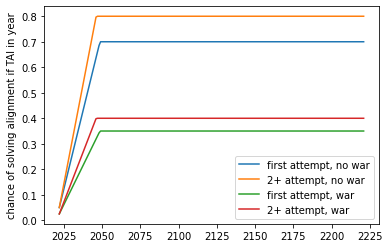

In [10]:
years = range(CURRENT_YEAR, MAX_YEAR)
alignment_p = np.array([p_alignment_solved(war=False, year=y - CURRENT_YEAR, first_attempt=True) for y in years])
alignment_p2 = np.array([p_alignment_solved(war=False, year=y - CURRENT_YEAR, first_attempt=False) for y in years])
alignment_pwar = np.array([p_alignment_solved(war=True, year=y - CURRENT_YEAR, first_attempt=True) for y in years])
alignment_p2war = np.array([p_alignment_solved(war=True, year=y - CURRENT_YEAR, first_attempt=False) for y in years])
plt.plot(years, alignment_p, label='first attempt, no war')
plt.plot(years, alignment_p2, label='2+ attempt, no war')
plt.plot(years, alignment_pwar, label='first attempt, war')
plt.plot(years, alignment_p2war, label='2+ attempt, war')
plt.legend()
plt.ylabel('chance of solving alignment if TAI in year')
# TODO: Make logistic?

In [11]:
for y in years:
    str_ = 'Year: {} - chance of solving TAI alignment with no war {}% (2nd attempt {}%)'
    print(str_.format(y,
                      round(alignment_p[y - CURRENT_YEAR] * 100, 0),
                      round(alignment_p2[y - CURRENT_YEAR] * 100, 0)))

Year: 2022 - chance of solving TAI alignment with no war 5.0% (2nd attempt 5.0%)
Year: 2023 - chance of solving TAI alignment with no war 7.0% (2nd attempt 8.0%)
Year: 2024 - chance of solving TAI alignment with no war 10.0% (2nd attempt 11.0%)
Year: 2025 - chance of solving TAI alignment with no war 12.0% (2nd attempt 14.0%)
Year: 2026 - chance of solving TAI alignment with no war 15.0% (2nd attempt 17.0%)
Year: 2027 - chance of solving TAI alignment with no war 17.0% (2nd attempt 21.0%)
Year: 2028 - chance of solving TAI alignment with no war 20.0% (2nd attempt 24.0%)
Year: 2029 - chance of solving TAI alignment with no war 22.0% (2nd attempt 27.0%)
Year: 2030 - chance of solving TAI alignment with no war 25.0% (2nd attempt 30.0%)
Year: 2031 - chance of solving TAI alignment with no war 27.0% (2nd attempt 33.0%)
Year: 2032 - chance of solving TAI alignment with no war 29.0% (2nd attempt 36.0%)
Year: 2033 - chance of solving TAI alignment with no war 32.0% (2nd attempt 39.0%)
Year: 20

In [12]:
for y in years:
    str_ = 'Year: {} - chance of solving TAI alignment with war {}% (2nd attempt {}%)'
    print(str_.format(y,
                      round(alignment_pwar[y - CURRENT_YEAR] * 100, 0),
                      round(alignment_p2war[y - CURRENT_YEAR] * 100, 0)))

Year: 2022 - chance of solving TAI alignment with war 2.0% (2nd attempt 2.0%)
Year: 2023 - chance of solving TAI alignment with war 4.0% (2nd attempt 4.0%)
Year: 2024 - chance of solving TAI alignment with war 5.0% (2nd attempt 6.0%)
Year: 2025 - chance of solving TAI alignment with war 6.0% (2nd attempt 7.0%)
Year: 2026 - chance of solving TAI alignment with war 7.0% (2nd attempt 9.0%)
Year: 2027 - chance of solving TAI alignment with war 9.0% (2nd attempt 10.0%)
Year: 2028 - chance of solving TAI alignment with war 10.0% (2nd attempt 12.0%)
Year: 2029 - chance of solving TAI alignment with war 11.0% (2nd attempt 13.0%)
Year: 2030 - chance of solving TAI alignment with war 12.0% (2nd attempt 15.0%)
Year: 2031 - chance of solving TAI alignment with war 14.0% (2nd attempt 16.0%)
Year: 2032 - chance of solving TAI alignment with war 15.0% (2nd attempt 18.0%)
Year: 2033 - chance of solving TAI alignment with war 16.0% (2nd attempt 20.0%)
Year: 2034 - chance of solving TAI alignment with w

## Great Power War

Text(0, 0.5, 'chance of great power war IN year')

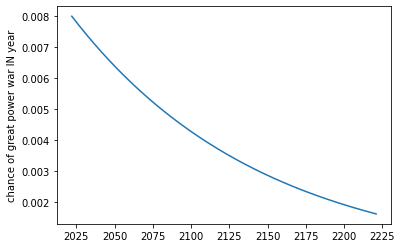

In [13]:
war_pdf = np.array([p_great_power_war(y - CURRENT_YEAR) for y in years])
war_pdf = [war_pdf[0] if x == 0 else war_pdf[x] * np.prod(1 - war_pdf[:x]) for x in range(MAX_YEAR - CURRENT_YEAR)]
plt.plot(years, war_pdf)
plt.ylabel('chance of great power war IN year')


Text(0, 0.5, 'chance of great power war BY year')

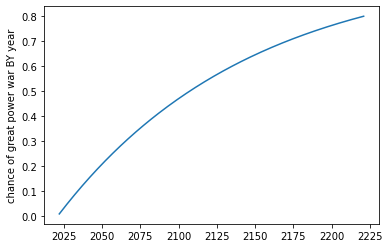

In [14]:
war_cdf = np.cumsum(war_pdf)
plt.plot(years, war_cdf)
plt.ylabel('chance of great power war BY year')


In [15]:
for y in years:
    print('Year: {} - chance of war IN year {}%, BY year {}%'.format(y,
                                                                     np.round(war_pdf[y - CURRENT_YEAR] * 100, 1),
                                                                     np.round(war_cdf[y - CURRENT_YEAR] * 100, 1)))

Year: 2022 - chance of war IN year 0.8%, BY year 0.8%
Year: 2023 - chance of war IN year 0.8%, BY year 1.6%
Year: 2024 - chance of war IN year 0.8%, BY year 2.4%
Year: 2025 - chance of war IN year 0.8%, BY year 3.2%
Year: 2026 - chance of war IN year 0.8%, BY year 3.9%
Year: 2027 - chance of war IN year 0.8%, BY year 4.7%
Year: 2028 - chance of war IN year 0.8%, BY year 5.5%
Year: 2029 - chance of war IN year 0.8%, BY year 6.2%
Year: 2030 - chance of war IN year 0.7%, BY year 7.0%
Year: 2031 - chance of war IN year 0.7%, BY year 7.7%
Year: 2032 - chance of war IN year 0.7%, BY year 8.4%
Year: 2033 - chance of war IN year 0.7%, BY year 9.2%
Year: 2034 - chance of war IN year 0.7%, BY year 9.9%
Year: 2035 - chance of war IN year 0.7%, BY year 10.6%
Year: 2036 - chance of war IN year 0.7%, BY year 11.3%
Year: 2037 - chance of war IN year 0.7%, BY year 12.0%
Year: 2038 - chance of war IN year 0.7%, BY year 12.7%
Year: 2039 - chance of war IN year 0.7%, BY year 13.4%
Year: 2040 - chance of 

In [16]:
war_length_p = sq.get_percentiles(sq.sample(war_length, n=1000), reverse=True)
war_length_p

{99: 0.9,
 95: 2.040816018894162,
 90: 2.8515623618063035,
 80: 4.208742818732114,
 70: 5.671631030656395,
 60: 7.523942873695359,
 50: 9.485147419177938,
 40: 11.991297341504996,
 30: 16.659318137993377,
 20: 22.498708145375925,
 10: 33.71607341041557,
 5: 45.20076839365383,
 1: 109.1123519492218}

## Run Model

### TAI Scenarios

In [17]:
def tai_scenarios_module(y, state, verbose):
    if state['tai_type'] != 'abandoned' and state['tai_type'] != 'tool' and state['tai']:
        # TODO: Slow vs. fast takeoff
        # TODO: May not deploy TAI as soon as it is deployable
        if (sq.event_occurs(p_make_agent_tai) or state['tai_type'] == 'agent') and state['tai_type'] != 'tool':
            # TODO: Do we want to re-roll the possibility of making agentic TAI in future years?
            if sq.event_occurs(p_tai_intentional_misuse(state['war'])):
                if sq.event_occurs(p_full_tai_misalignment_averted):
                    state['averted_misalignment'] = True
                    if sq.event_occurs(p_tai_misalignment_averting_is_catastrophic):
                        # TODO: Right now this guarantees abandonment if catastrophe - revise?
                        if verbose:
                            print('{}: ...Intentional misuse of TAI happened, was averted with catastrophe, and we abandon TAI'.format(y))
                        state['tai'] = True; state['tai_type'] = 'abandoned'
                        state['catastrophe'].append('averting_intentional_tai')
                        # TODO: Maybe resume TAI with lower chance of happening?
                    elif sq.event_occurs(p_full_tai_misalignment_averted_means_abandoned_tai):
                        if verbose:
                            print('{}: ...Intentional misuse of TAI happened, it was averted with no catastrophe, and we abandon TAI'.format(y))
                        state['tai'] = True; state['tai_type'] = 'abandoned'    
                        # TODO: Maybe resume TAI with lower chance of happening?
                    elif verbose:
                        print('{}: ...Intentional misuse of TAI happened, but it was averted'.format(y))
                else:
                    if verbose:
                        print('{}: ...XRISK from intentional misuse of TAI (singleton) :('.format(y))
                    state['category'] = 'xrisk_tai_misuse'; state['tai'] = True; state['tai_type'] = 'agent'
                    if sq.event_occurs(p_tai_singleton_is_catastrophic):
                        if verbose:
                            print('...Singleton is catastrophic')
                        state['catastrophe'].append(state['category'])
                    state['terminate'] = True; state['final_year'] = y
            elif sq.event_occurs(p_alignment_solved(state['war'], y - CURRENT_YEAR, first_attempt=not state['tai'], verbose=verbose)):
                if sq.event_occurs(p_subtle_alignment_solved):
                    if verbose:
                        print('{}: ...Achieved aligned TAI (aligned via work, {} attempt), happy future! :D'.format(y, '2nd+' if state['tai'] else 'first'))
                    state['category'] = 'aligned_tai'; state['tai'] = True; state['tai_type'] = 'agent'
                    state['terminate'] = True; state['final_year'] = y
                else:
                    if verbose:
                        print('{}: ...XRISK from subtly unaligned TAI :('.format(y))
                    state['category'] = 'xrisk_subtly_unaligned_tai'; state['tai'] = True; state['tai_type'] = 'agent'
                    state['terminate'] = True; state['final_year'] = y
            elif sq.event_occurs(p_tai_aligned_by_default):
                if sq.event_occurs(p_subtle_alignment_solved_if_aligned_by_default):
                    if verbose:
                        print('{}: ...Achieved aligned TAI (aligned by default), happy future! :D'.format(y))
                    state['category'] = 'aligned_tai'; state['tai'] = True; state['tai_type'] = 'agent'
                    state['terminate'] = True; state['final_year'] = y
                    # TODO: Does aligned TAI make all other xrisks impossible? We currently assume it does
                        # TODO: Maybe introduce takeoff delay before other xrisks become impossible?
                else:
                    if verbose:
                        print('{}: ...XRISK from subtly unaligned TAI :('.format(y))
                    state['category'] = 'xrisk_subtly_unaligned_tai'; state['tai'] = True; state['tai_type'] = 'agent'
                    state['terminate'] = True; state['final_year'] = y
            elif sq.event_occurs(p_full_tai_misalignment_averted):
                state['averted_misalignment'] = True
                if sq.event_occurs(p_tai_misalignment_averting_is_catastrophic):
                    # TODO: Right now this guarantees abandonment if catastrophe - revise?
                    if verbose:
                        print('{}: ...Misaligned TAI happened, it was averted with catastrophe, and we abandon TAI'.format(y))
                    state['tai'] = True; state['tai_type'] = 'abandoned'
                    state['catastrophe'].append('averting_misaligned_tai')
                    # TODO: Maybe resume TAI with lower chance of happening?
                elif sq.event_occurs(p_full_tai_misalignment_averted_means_abandoned_tai):
                    if verbose:
                        print('{}: ...Misaligned TAI happened, it was averted with no catastrophe, and we abandon TAI'.format(y))
                    state['tai'] = True; state['tai_type'] = 'abandoned'    
                    # TODO: Maybe resume TAI with lower chance of happening?
                elif verbose:
                    print('{}: ...Misaligned TAI happened, but it was averted'.format(y))
                    state['tai'] = True; state['tai_type'] = 'agent'
            elif sq.event_occurs(p_tai_xrisk_is_extinction):
                if verbose:
                    print('{}: ...XRISK from fully unaligned TAI (extinction) :('.format(y))
                state['category'] = 'xrisk_full_unaligned_tai_extinction'; state['tai'] = True; state['tai_type'] = 'agent'
                state['catastrophe'].append(state['category'])
                state['terminate'] = True; state['final_year'] = y
            else:
                if verbose:
                    print('{}: ...XRISK from fully unaligned TAI (singleton) :('.format(y))
                state['category'] = 'xrisk_full_unaligned_tai_singleton'; state['tai'] = True; state['tai_type'] = 'agent'
                if sq.event_occurs(p_tai_singleton_is_catastrophic):
                    if verbose:
                        print('...Singleton is catastrophic')
                    state['catastrophe'].append(state['category'])
                state['terminate'] = True; state['final_year'] = y
        else: # tool TAI
            if verbose:
                print('{}: ...Tool TAI made'.format(y))
            state['tai'] = True; state['tai_type'] = 'tool'
            # TODO: Does tool AI help mitigate xrisk?
    return state
            
    # TODO: TAI or nearness to TAI creates great power war
    # TODO: War may slow down or speed up TAI, may also increase willingness to spend
    # TODO: Catastrophes may slow down TAI
print('Loaded TAI scenarios module')


Loaded TAI scenarios module


### Great Power War Scenarios Module

In [18]:
def great_power_war_scenarios_module(y, state, verbose):
    if sq.event_occurs(p_great_power_war(y - CURRENT_YEAR)) and not state['war']:
        if verbose:
            print('{}: WAR!!!'.format(y))
        state['war'] = True
        war_end_year = sq.sample(war_length) + y    
        
        if state['war'] and (y >= war_end_year or state['category'] == 'aligned_tai'):
            if verbose:
                print('{}: War ends :)'.format(y))
            state['war'] = False
        
    return state

print('Loaded great power war scenarios module')

Loaded great power war scenarios module


### Nuclear Scenarios Module

In [19]:
def nuclear_scenarios_module(y, state, verbose):
    if sq.event_occurs(p_nuclear_accident(state['war'], y - CURRENT_YEAR)):
        state['nuclear_weapon_used'] = True
        if sq.event_occurs(p_catastrophe_from_nuclear_exchange(state['war'])):
            if sq.event_occurs(p_xrisk_from_nuclear_catastrophe(state['war'])):
                if verbose:
                    print('{}: ...XRISK from nukes (accidental exchange) :('.format(y))
                state['category'] = 'xrisk_nukes_accident'
                state['terminate'] = True; state['final_year'] = y
            else:    
                if verbose:
                    print('{}: ...catastrophe from nukes (accidental exchange)'.format(y))
                state['catastrophe'].append('nukes_accident')

    if not state['terminate'] and state['war'] and sq.event_occurs(p_nuclear_war_given_war):
        state['nuclear_weapon_used'] = True
        if sq.event_occurs(p_catastrophe_from_nuclear_exchange(state['war'])):
            if sq.event_occurs(p_xrisk_from_nuclear_catastrophe(state['war'])):
                if verbose:
                    print('{}: ...XRISK from nukes (war) :('.format(y))
                state['category'] = 'xrisk_nukes_war'
                state['terminate'] = True; state['final_year'] = y
            else:    
                if verbose:
                    print('{}: ...catastrophe from nukes (war)'.format(y))
                state['catastrophe'].append('nukes_war')

                
    return state

print('Loaded nuclear scenarios module')

Loaded nuclear scenarios module


### Bio scenarios module

In [20]:
def bio_scenarios_module(y, state, verbose):
    if sq.event_occurs(p_natural_bio(y - CURRENT_YEAR)):
        state['natural_pathogen'] = True
        if sq.event_occurs(p_natural_bio_is_catastrophe):
            if sq.event_occurs(p_xrisk_from_accidental_bio_given_catastrophe(y - CURRENT_YEAR)):
                if verbose:
                    print('{}: ...XRISK from pathogen (lab-leak) :('.format(y))
                state['category'] = 'xrisk_bio_accident'
                state['terminate'] = True; state['final_year'] = y
            else:
                if verbose:
                    print('{}: ...catastrophe from natural pathogen'.format(y))
                state['catastrophe'].append('natural_pathogen')

    if not state['terminate'] and sq.event_occurs(p_accidental_bio(state['war'])):
        engineered = sq.event_occurs(ratio_engineered_vs_natural_lab_leak)
        if sq.event_occurs(p_engineered_bio_is_catastrophe):
            if sq.event_occurs(p_xrisk_from_accidental_bio_given_catastrophe(y - CURRENT_YEAR)):
                if verbose:
                    print('{}: ...XRISK from pathogen (lab-leak) :('.format(y))
                state['category'] = 'xrisk_bio_accident'
                state['terminate'] = True; state['final_year'] = y
            else:
                if verbose:
                    if engineered:
                        print('{}: ...catastrophe from lab-leak engineered pathogen'.format(y))
                    else:
                        print('{}: ...catastrophe from lab-leak natural pathogen'.format(y))
                state['catastrophe'].append('engineered_pathogen' if engineered else 'natural_pathogen')
    
    if not state['terminate'] and state['war'] and sq.event_occurs(p_biowar_given_war):
        if sq.event_occurs(p_engineered_bio_is_catastrophe):
            if sq.event_occurs(p_xrisk_from_engineered_bio_given_catastrophe(y - CURRENT_YEAR)):
                if verbose:
                    print('{}: ...XRISK from pathogen (war) :('.format(y))
                state['category'] = 'xrisk_bio_war'
                state['terminate'] = True; state['final_year'] = y
            else:
                if verbose:
                    print('{}: ...catastrophe from pathogen (war)'.format(y))
                state['catastrophe'].append('engineered_pathogen')
    
    if not state['terminate'] and sq.event_occurs(p_nonstate_bio):
        engineered = sq.event_occurs(ratio_engineered_vs_natural_lab_leak)
        if sq.event_occurs(p_engineered_bio_is_catastrophe):
            if sq.event_occurs(p_xrisk_from_engineered_bio_given_catastrophe(y - CURRENT_YEAR)):
                if verbose:
                    print('{}: ...XRISK from pathogen (nonstate) :('.format(y))
                state['category'] = 'xrisk_bio_nonstate'
                state['terminate'] = True; state['final_year'] = y
            else:
                if verbose:
                    if engineered:
                        print('{}: ...catastrophe from engineered pathogen'.format(y))
                    else:
                        print('{}: ...catastrophe from natural pathogen'.format(y))
                state['catastrophe'].append('engineered_pathogen' if engineered else 'natural_pathogen')
                
    return state

print('Loaded bio scenarios module')

Loaded bio scenarios module


### Nanotech scenarios module

In [21]:
def nano_scenarios_module(y, state, verbose):
    if sq.event_occurs(p_nanotech_possible(y - CURRENT_YEAR)) and not state['nano']:
        state['nano'] = True
        if sq.event_occurs(p_nanotech_is_xrisk):
            if verbose:
                print('{}: ...XRISK from nanotech :('.format(y))
            state['category'] = 'xrisk_nanotech'
            state['catastrophe'].append(state['category'])
            state['terminate'] = True; state['final_year'] = y
        # TODO: Catastrophic but non x-risk nano?
        # TODO: catastrophe or nano x-risk but not in the first year?
                        
    return state

print('Loaded nano scenarios module')

Loaded nano scenarios module


### Supervolcano scenarios module (all other natural risks <0.01%)

In [22]:
def supervolcano_scenarios_module(y, state, verbose):
    if sq.event_occurs(p_supervolcano_catastrophe):
        if sq.event_occurs(p_supervolcano_extinction_given_catastrophe):
            if verbose:
                print('{}: ...XRISK from supervolcano'.format(y))
            state['category'] = 'xrisk_supervolcano'
            state['catastrophe'].append(state['category'])
            state['terminate'] = True; state['final_year'] = y
        else:
            if verbose:
                print('{}: ...Catastrophe from supervolcano'.format(y))
            state['catastrophe'].append('supervolcano')
            
    return state

print('Loaded supervolcano module')

Loaded supervolcano module


### Unknown unknown scenarios module

In [23]:
def unknown_unknown_scenarios_module(y, state, verbose):
    if sq.event_occurs(p_unknown_unknown_xrisk(y - CURRENT_YEAR)):
        if verbose:
            print('{}: ...XRISK from unknown unknown'.format(y))
        state['category'] = 'xrisk_unknown_unknown'
        state['catastrophe'].append(state['category'])
        # TODO: What % of "unknown unknowns" are extinction?
        # TODO: catastrophic but not x-risk unknown unknowns?
        state['terminate'] = True; state['final_year'] = y
        
    return state

print('Loaded unknown unknown scenarios module')

Loaded unknown unknown scenarios module


### Overall module structure

In [24]:
def define_event(verbose=False):
    state = {'category': 'boring', 'tai': False, 'tai_year': None, 'tai_type': None, 'nano': False,
             'war': False, 'engineered_pathogen': False, 'natural_pathogen': False,
             'averted_misalignment': False, 'nuclear_weapon_used': False, 'catastrophe': [],
             'terminate': False, 'final_year': None}
    collectors = {}
    
    ## Set up timelines calculations
    if use_efficiency_based_algo_reduction:
        efficiency_ = sq.sample(efficiency)
        tai_flop_size_ = sq.sample(lambda: tai_flop_size(efficiency=sq.const(efficiency_),
                                                         debug=verbose))
    else:
        tai_flop_size_ = sq.sample(tai_flop_size)

    if tai_flop_size_ > 300:
        tai_flop_size_ = int(tai_flop_size_) # Handle overflow errors
    
    algo_doubling_rate_ = algo_halving_fn(sq.sample(algo_doubling_rate_min),
                                          sq.sample(algo_doubling_rate_max),
                                          tai_flop_size_)
    
    if use_efficiency_based_algo_reduction:
        possible_algo_reduction_ = possible_algo_reduction_fn(efficiency_, efficiency_, tai_flop_size_)
        if efficiency_based_additional_reduction:
            possible_algo_reduction_ += sq.sample(efficiency_based_additional_reduction)
    else:
        possible_algo_reduction_ = possible_algo_reduction_fn(sq.sample(min_reduction),
                                                              sq.sample(max_reduction),
                                                              tai_flop_size_)
    
    initial_flops_per_dollar_ = 10 ** sq.sample(initial_flops_per_dollar)
    flops_halving_rate_ = sq.sample(flops_halving_rate)
    max_flops_per_dollar_ = 10 ** sq.sample(max_flops_per_dollar)
    initial_pay_ = 10 ** sq.sample(initial_pay)
    gdp_growth_ = sq.sample(gdp_growth)
    max_gdp_frac_ = sq.sample(max_gdp_frac)
    
    willingness_ramp_happens = sq.event_occurs(p_willingness_ramp)
    if willingness_ramp_happens:
        willingness_ramp_ = sq.sample(willingness_ramp)
    else:
        willingness_ramp_ = 1
    
    initial_gdp_ = initial_gdp
    spend_doubling_time_ = sq.sample(spend_doubling_time)
    nonscaling_delay_ = sq.sample(nonscaling_delay)
    initial_chance_of_nonscaling_issue_ = initial_chance_of_nonscaling_issue
    final_chance_of_nonscaling_issue_ = final_chance_of_nonscaling_issue
    nonscaling_issue_bottom_year_ = nonscaling_issue_bottom_year
    willingness_spend_horizon_ = int(sq.sample(willingness_spend_horizon))
    
    queue_tai_year = 99999
    plt.ioff()
    if verbose:
        cost_of_tai_collector = []
        willingness_collector = []
    
    if verbose:
        print('### TAI TIMELINE VARIABLES ###')
        print('It takes {} log FLOPs (~{}) for transformative capabilities.'.format(np.round(tai_flop_size_, 1),
                                                                                    numerize(10 ** tai_flop_size_)))
        print('Every {} years algorithms get 2x better, with {} log reductions possible.'.format(np.round(algo_doubling_rate_, 1),
                                                                                                 np.round(possible_algo_reduction_, 1)))
        print(('FLOPs start at a cost of {} log FLOPs (~{}) per 2022$USD. Every {} years they get ' +
               '2x cheaper, to a maximum of {} log FLOPs (~{}) per 2022$USD.').format(np.round(math.log10(initial_flops_per_dollar_), 1),
                                                                               numerize(initial_flops_per_dollar_),
                                                                               np.round(flops_halving_rate_, 1),
                                                                               np.round(math.log10(max_flops_per_dollar_), 1),
                                                                               numerize(max_flops_per_dollar_)))
        print(('We are willing to pay {} log 2022$USD (~{}) and this increases by {}x per year to a max of {}% of GDP. ' +
               'GDP grows at a rate of {}x per year.').format(np.round(math.log10(initial_pay_), 1),
                                                              numerize(initial_pay_),
                                                              np.round(spend_doubling_time_, 1),
                                                              np.round(max_gdp_frac_, 4),
                                                              np.round(gdp_growth_, 3)))
        if willingness_ramp_ < 1:
            print('In this simulation, if we are {}% of the way to paying for TAI, we will ramp to paying for TAI.'.format(np.round(willingness_ramp_ * 100)))

        if willingness_spend_horizon_ > 1:
            print('We are willing to spend over {} years to make TAI'.format(willingness_spend_horizon_))
            
        print(('If a non-scaling delay happens, it will take an additional {} years to produce TAI due' +
               ' to issues unrelated to scaling FLOP').format(np.round(nonscaling_delay_, 1)))
        print('-')
    
    is_nonscaling_issue = None

    for y in years:

        # Check if TAI is created this year
        if not state['tai']:
            flops_needed_ = flops_needed(initial_flops=10 ** tai_flop_size_,
                                         doubling_rate=algo_doubling_rate_,
                                         possible_reduction=10 ** possible_algo_reduction_,
                                         year=(y - CURRENT_YEAR))

            flops_per_dollar_ = flops_per_dollar(initial_flops_per_dollar=initial_flops_per_dollar_,
                                                 max_flops_per_dollar=max_flops_per_dollar_,
                                                 halving_rate=flops_halving_rate_,
                                                 year=(y - CURRENT_YEAR))

            if flops_per_dollar_ > 10 ** 200 or flops_needed_ > 10 ** 200:
                flops_needed_ = int(flops_needed_)
                flops_per_dollar_ = int(flops_per_dollar_)
                cost_of_tai_ = flops_needed_ // flops_per_dollar_
            else:
                cost_of_tai_ = flops_needed_ / flops_per_dollar_

            willingness_ = willingness_to_pay(initial_gdp=initial_gdp_,
                                              gdp_growth=gdp_growth_,
                                              initial_pay=initial_pay_,
                                              spend_doubling_time=spend_doubling_time_,
                                              max_gdp_frac=max_gdp_frac_,
                                              year=(y - CURRENT_YEAR))

            if flops_per_dollar_ > 10 ** 200:
                willingness_ = int(willingness_)
            if willingness_ > 10 ** 200:
                flops_per_dollar_ = int(flops_per_dollar_)

            if verbose:
                cost_of_tai_collector.append(cost_of_tai_)
                willingness_collector.append(willingness_)

            total_compute_ = willingness_ * flops_per_dollar_

            if verbose == 2:
                out_str = ('Year: {} - {} max log FLOP ({}) available - TAI takes {} log FLOP ({}) - ' +
                           'log $ {} to buy TAI ({}) vs. willingness to pay log $ {} ({}) - {} log FLOPS per $ ({})')
                print(out_str.format(y,
                                     np.round(math.log10(total_compute_), 1),
                                     numerize(total_compute_),
                                     np.round(math.log10(flops_needed_), 1),
                                     numerize(flops_needed_),
                                     np.round(math.log10(cost_of_tai_), 1),
                                     numerize(cost_of_tai_),
                                     np.round(math.log10(willingness_), 1),
                                     numerize(willingness_),
                                     np.round(math.log10(flops_per_dollar_), 1),
                                     numerize(flops_per_dollar_)))

            if cost_of_tai_ > 10 ** 200:
                spend_tai_years = int(cost_of_tai_) // int(willingness_)
            else:
                spend_tai_years = cost_of_tai_ / willingness_

            if not is_nonscaling_issue and queue_tai_year < 99999 and verbose == 2:
                print('-$- {}/{}'.format(y, queue_tai_year))
            if (cost_of_tai_ * willingness_ramp_) <= willingness_ or y >= queue_tai_year:
                if is_nonscaling_issue is None:
                    p_nonscaling_delay_ = p_nonscaling_delay(initial_chance_of_nonscaling_issue_,
                                                             final_chance_of_nonscaling_issue_,
                                                             year=y,
                                                             max_year=nonscaling_issue_bottom_year_)
                    r_ = random.random()
                    is_nonscaling_issue = r_ < p_nonscaling_delay_
                    nonscaling_countdown = nonscaling_delay_
                    if verbose == 2:
                        print('-- {} p_nonscaling_issue={} r_={}'.format('Nonscaling delay occured' if is_nonscaling_issue else 'Nonscaling issue did not occur',
                                                                         np.round(p_nonscaling_delay_, 4),
                                                                         np.round(r_, 4)))

                if not is_nonscaling_issue or nonscaling_countdown <= 0.1:
                    if verbose:
                        print('--- /!\ TAI CREATED in {}'.format(y))
                        plot_tai(plt, years, cost_of_tai_collector, willingness_collector).show()
                    state['tai'] = True
                    state['tai_year'] = y
                else:
                    if verbose == 2:
                        print('{}: /!\ FLOPs for TAI sufficient but needs {} more years to solve non-scaling issues'.format(y, np.round(nonscaling_countdown, 1)))
                    nonscaling_countdown -= 1
            elif (not is_nonscaling_issue and willingness_spend_horizon_ > 1 and
                  spend_tai_years <= willingness_spend_horizon_ and y + math.ceil(spend_tai_years) < queue_tai_year):
                queue_tai_year = y + math.ceil(spend_tai_years)
                if verbose == 2:
                    print('-$- We have enough spend to make TAI in {} years (in {}) if sustained.'.format(math.ceil(spend_tai_years),
                                                                                                          queue_tai_year))
        
        
        # Run modules
        if not state['terminate']:
            state = tai_scenarios_module(y, state, verbose)
        
        if not state['terminate']:
            state = great_power_war_scenarios_module(y, state, verbose)
        
        if not state['terminate']:
            state = nuclear_scenarios_module(y, state, verbose)
        
        if not state['terminate']:
            state = bio_scenarios_module(y, state, verbose)
        
        if not state['terminate']:
            state = nano_scenarios_module(y, state, verbose)
        
        if not state['terminate']:
            state = supervolcano_scenarios_module(y, state, verbose)
        
        if not state['terminate']:
            state = unknown_unknown_scenarios_module(y, state, verbose)

        ## Run collectors
        collectors[y] = deepcopy(state)
                
    ## Boring future if MAX_YEAR is reached with no termination
    if not state['terminate']:
        if verbose:
            print('...Boring future')
        state['final_year'] = '>{}'.format(y)

    if verbose:
        print('-')
        print('-')
    
    tai_metadata = {'initial_gdp': initial_gdp_,
                    'tai_flop_size': tai_flop_size_,
                    'nonscaling_delay': nonscaling_delay_,
                    'algo_doubling_rte': algo_doubling_rate_,
                    'possible_algo_reduction': possible_algo_reduction_,
                    'initial_flops_per_dollar': initial_flops_per_dollar_,
                    'flops_halving_rate': flops_halving_rate_,
                    'max_flops_per_dollar': max_flops_per_dollar_,
                    'initial_pay': initial_pay_,
                    'gdp_growth': gdp_growth_,
                    'max_gdp_frac': max_gdp_frac_,
                    'willingness_ramp_': willingness_ramp_,
                    'spend_doubling_time_': spend_doubling_time_,
                    'initial_chance_of_nonscaling_issue': initial_chance_of_nonscaling_issue_,
                    'final_chance_of_nonscaling_issue': final_chance_of_nonscaling_issue_,
                    'nonscaling_issue_bottom_year': nonscaling_issue_bottom_year_,
                    'willingness_spend_horizon_': willingness_spend_horizon_}
        
    return {'collectors': collectors,
            'tai_metadata': tai_metadata,
            'final_state': state}


print('Model loaded')


Model loaded


Anchor debug:
-- 29.4 = 12.2 + 3.1 + 0.3 + 0.3 + 12 - 0.494 * 11.2 + 0.494 * (12.2 + 3.1 - 1.1)
-- 29.4 after Bayes update
-
### TAI TIMELINE VARIABLES ###
It takes 29.4 log FLOPs (~254 octillion) for transformative capabilities.
Every 2.1 years algorithms get 2x better, with 4.1 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 3.6 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 3.7x per year to a max of 0.81% of GDP. GDP grows at a rate of 1.027x per year.
If a non-scaling delay happens, it will take an additional 1.8 years to produce TAI due to issues unrelated to scaling FLOP
-
Year: 2022 - 25.1 max log FLOP (13 septillion) available - TAI takes 29.4 log FLOP (254 octillion) - log $ 11.4 to buy TAI (254 billion) vs. willingness to pay log $ 7.1 (13 million) - 18.0 log FLOPS per $ (1000 quadrillion)
Year: 2023 - 25.3 m

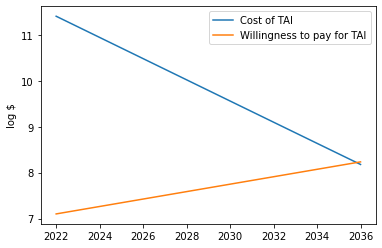

2036: ...XRISK from intentional misuse of TAI (singleton) :(
...Singleton is catastrophic
-
-
{'collectors': {2022: {'averted_misalignment': False,
                       'catastrophe': [],
                       'category': 'boring',
                       'engineered_pathogen': False,
                       'final_year': None,
                       'nano': False,
                       'natural_pathogen': False,
                       'nuclear_weapon_used': False,
                       'tai': False,
                       'tai_type': None,
                       'tai_year': None,
                       'terminate': False,
                       'war': False},
                2023: {'averted_misalignment': False,
                       'catastrophe': [],
                       'category': 'boring',
                       'engineered_pathogen': False,
                       'final_year': None,
                       'nano': False,
                       'natural_pathogen': False,
   

                       'catastrophe': ['xrisk_tai_misuse'],
                       'category': 'xrisk_tai_misuse',
                       'engineered_pathogen': False,
                       'final_year': 2036,
                       'nano': False,
                       'natural_pathogen': False,
                       'nuclear_weapon_used': True,
                       'tai': True,
                       'tai_type': 'agent',
                       'tai_year': 2036,
                       'terminate': True,
                       'war': False},
                2197: {'averted_misalignment': False,
                       'catastrophe': ['xrisk_tai_misuse'],
                       'category': 'xrisk_tai_misuse',
                       'engineered_pathogen': False,
                       'final_year': 2036,
                       'nano': False,
                       'natural_pathogen': False,
                       'nuclear_weapon_used': True,
                       'tai': True,
       

In [25]:
pprint(define_event(verbose=2))

-
-
############
## RUN 1 ##
############
Anchor debug:
-- Assume human brain in inference takes 13.2 log FLOP
-- Add 3.5 log FLOP for efficiency
-- Assume a transformative model takes -2.1 log FLOP compared to human
-- Assume a horizon length of 3.8
-- Assume a scaling exponent of 1.453
-- Assume FLOPs per param per sec of 1.7
-- 36.0 = 13.2 + 3.5 + -2.1 + 3.8 + 12 - 1.453 * 11.2 + 1.453 * (13.2 + 3.5 - 1.7)
-- 36.0 after Bayes update
-
### TAI TIMELINE VARIABLES ###
It takes 36.0 log FLOPs (~1 thousand decillion) for transformative capabilities.
Every 2.2 years algorithms get 2x better, with 4.9 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 3.3 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.9 log 2022$USD (~82 million) and this increases by 3.8x per year to a max of 0.81% of GDP. GDP grows at a rate of 1.027x per year.
If a non-scaling delay happens, it will take a

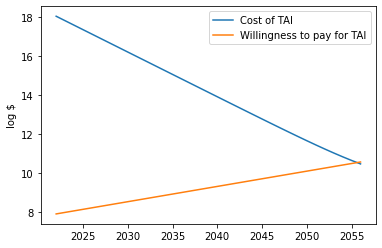

2056: ...Achieved aligned TAI (aligned via work, 2nd+ attempt), happy future! :D
-
-
-
-
############
## RUN 2 ##
############
Anchor debug:
-- Assume human brain in inference takes 10.2 log FLOP
-- Add 3.0 log FLOP for efficiency
-- Assume a transformative model takes 0.6 log FLOP compared to human
-- Assume a horizon length of 8.7
-- Assume a scaling exponent of 0.626
-- Assume FLOPs per param per sec of 1.6
-- 34.8 = 10.2 + 3.0 + 0.6 + 8.7 + 12 - 0.626 * 11.2 + 0.626 * (10.2 + 3.0 - 1.6)
-- 34.8 after Bayes update
-
### TAI TIMELINE VARIABLES ###
It takes 34.8 log FLOPs (~68 decillion) for transformative capabilities.
Every 1.7 years algorithms get 2x better, with 3.7 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 2.6 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 4.0x per year to a max of 0.81% of GDP. GDP grows a

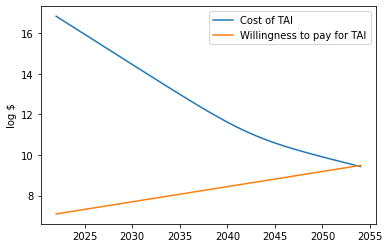

2054: ...XRISK from fully unaligned TAI (singleton) :(
...Singleton is catastrophic
-
-
-
-
############
## RUN 3 ##
############
Anchor debug:
-- Assume human brain in inference takes 18.1 log FLOP
-- Add 0 log FLOP for efficiency
-- Assume a transformative model takes -1.7 log FLOP compared to human
-- Assume a horizon length of 0
-- Assume a scaling exponent of 1.34
-- Assume FLOPs per param per sec of 2.6
-- 34.2 = 18.1 + 0 + -1.7 + 0 + 12 - 1.34 * 11.2 + 1.34 * (18.1 + 0 - 2.6)
-- 34.2 after Bayes update
-
### TAI TIMELINE VARIABLES ###
It takes 34.2 log FLOPs (~15 decillion) for transformative capabilities.
Every 1.6 years algorithms get 2x better, with 0 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 3.5 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 5.0x per year to a max of 0.81% of GDP. GDP grows at a rate o

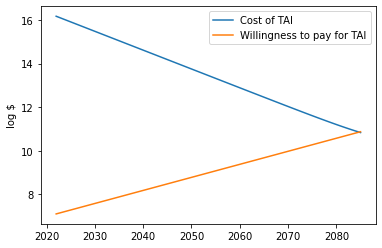

2085: ...Achieved aligned TAI (aligned via work, 2nd+ attempt), happy future! :D
-
-
-
-
############
## RUN 4 ##
############
Anchor debug:
-- Assume human brain in inference takes 17.2 log FLOP
-- Add 1.9 log FLOP for efficiency
-- Assume a transformative model takes -0.8 log FLOP compared to human
-- Assume a horizon length of 0
-- Assume a scaling exponent of 1.024
-- Assume FLOPs per param per sec of 1.9
-- 36.5 = 17.2 + 1.9 + -0.8 + 0 + 12 - 1.024 * 11.2 + 1.024 * (17.2 + 1.9 - 1.9)
-- 36.5 after Bayes update
-
### TAI TIMELINE VARIABLES ###
It takes 36.5 log FLOPs (~3 thousand decillion) for transformative capabilities.
Every 1.6 years algorithms get 2x better, with 3.6 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 3.3 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 3.0x per year to a max of 0.81% of GDP. GDP g

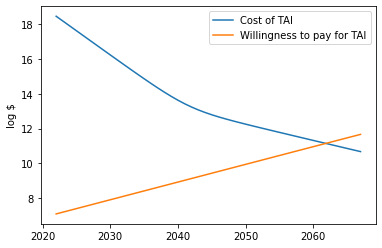

2067: ...XRISK from subtly unaligned TAI :(
-
-
-
-
############
## RUN 5 ##
############
Anchor debug:
-- Assume human brain in inference takes 12.7 log FLOP
-- Add 0 log FLOP for efficiency
-- Assume a transformative model takes -0.9 log FLOP compared to human
-- Assume a horizon length of 5.9
-- Assume a scaling exponent of 0.945
-- Assume FLOPs per param per sec of 1.0
-- 30.2 = 12.7 + 0 + -0.9 + 5.9 + 12 - 0.945 * 11.2 + 0.945 * (12.7 + 0 - 1.0)
-- 30.2 after Bayes update
-
### TAI TIMELINE VARIABLES ###
It takes 30.2 log FLOPs (~2 nonillion) for transformative capabilities.
Every 2.3 years algorithms get 2x better, with 0 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 3.0 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 8.2 log 2022$USD (~149 million) and this increases by 4.9x per year to a max of 0.81% of GDP. GDP grows at a rate of 1.027x per year.
If a non-scali

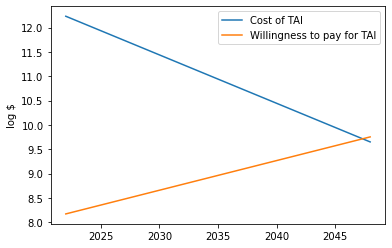

2048: ...XRISK from intentional misuse of TAI (singleton) :(
...Singleton is catastrophic
-
-
-
-
############
## RUN 6 ##
############
Anchor debug:
-- Assume human brain in inference takes 17.2 log FLOP
-- Add 1.3 log FLOP for efficiency
-- Assume a transformative model takes -1.3 log FLOP compared to human
-- Assume a horizon length of 0
-- Assume a scaling exponent of 1.06
-- Assume FLOPs per param per sec of 1.2
-- 35.6 = 17.2 + 1.3 + -1.3 + 0 + 12 - 1.06 * 11.2 + 1.06 * (17.2 + 1.3 - 1.2)
-- 35.6 after Bayes update
-
### TAI TIMELINE VARIABLES ###
It takes 35.6 log FLOPs (~426 decillion) for transformative capabilities.
Every 1.5 years algorithms get 2x better, with 3.2 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 3.7 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 5.5x per year to a max of 0.81% of GDP. GDP gr

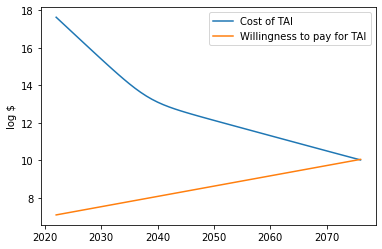

2076: ...Tool TAI made
2101: ...catastrophe from nukes (war)
2124: ...catastrophe from lab-leak engineered pathogen
2148: ...catastrophe from nukes (accidental exchange)
2183: ...catastrophe from pathogen (war)
2211: ...catastrophe from nukes (war)
...Boring future
-
-
-
-
############
## RUN 7 ##
############
Anchor debug:
-- Assume human brain in inference takes 14.9 log FLOP
-- Add 3.6 log FLOP for efficiency
-- Assume a transformative model takes -0.7 log FLOP compared to human
-- Assume a horizon length of 5.4
-- Assume a scaling exponent of 0.898
-- Assume FLOPs per param per sec of 0.9
-- 40.9 = 14.9 + 3.6 + -0.7 + 5.4 + 12 - 0.898 * 11.2 + 0.898 * (14.9 + 3.6 - 0.9)
-- 40.9 after Bayes update
-
### TAI TIMELINE VARIABLES ###
It takes 40.9 log FLOPs (~74 million decillion) for transformative capabilities.
Every 1.9 years algorithms get 2x better, with 5.6 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 1.9 years they get 2x c

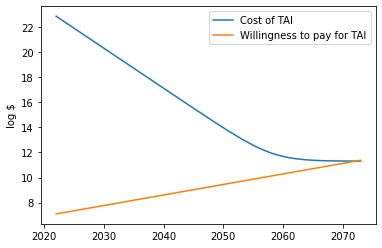

2073: ...XRISK from fully unaligned TAI (singleton) :(
...Singleton is catastrophic
-
-
-
-
############
## RUN 8 ##
############
Anchor debug:
-- Assume human brain in inference takes 13.1 log FLOP
-- Add 1.0 log FLOP for efficiency
-- Assume a transformative model takes -1.3 log FLOP compared to human
-- Assume a horizon length of 2.2
-- Assume a scaling exponent of 0.994
-- Assume FLOPs per param per sec of 1.7
-- 28.3 = 13.1 + 1.0 + -1.3 + 2.2 + 12 - 0.994 * 11.2 + 0.994 * (13.1 + 1.0 - 1.7)
-- 28.3 after Bayes update
-
### TAI TIMELINE VARIABLES ###
It takes 28.3 log FLOPs (~19 octillion) for transformative capabilities.
Every 2.9 years algorithms get 2x better, with 2.4 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 4.6 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 5.4x per year to a max of 0.81% of GDP. GDP gr

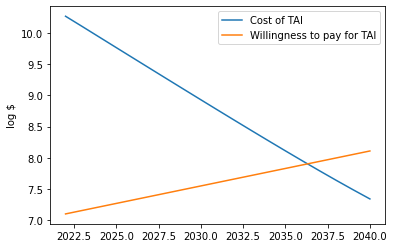

2040: ...Tool TAI made
2090: WAR!!!
2133: ...catastrophe from nukes (accidental exchange)
2157: ...catastrophe from nukes (accidental exchange)
2165: ...catastrophe from nukes (accidental exchange)
2166: ...catastrophe from nukes (accidental exchange)
2175: ...catastrophe from nukes (accidental exchange)
2209: ...catastrophe from nukes (accidental exchange)
...Boring future
-
-
-
-
############
## RUN 9 ##
############
Anchor debug:
-- Assume human brain in inference takes 13.7 log FLOP
-- Add 1.7 log FLOP for efficiency
-- Assume a transformative model takes 0.6 log FLOP compared to human
-- Assume a horizon length of 0
-- Assume a scaling exponent of 0.802
-- Assume FLOPs per param per sec of 1.7
-- 30.1 = 13.7 + 1.7 + 0.6 + 0 + 12 - 0.802 * 11.2 + 0.802 * (13.7 + 1.7 - 1.7)
-- 30.1 after Bayes update
-
### TAI TIMELINE VARIABLES ###
It takes 30.1 log FLOPs (~1 nonillion) for transformative capabilities.
Every 2.2 years algorithms get 2x better, with 3.3 log reductions possible.
FLOP

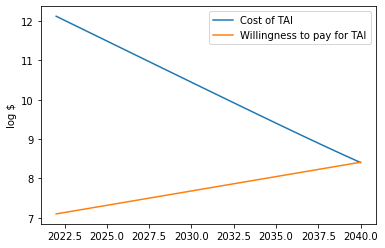

2040: ...Achieved aligned TAI (aligned via work, 2nd+ attempt), happy future! :D
-
-
-
-
############
## RUN 10 ##
############
Anchor debug:
-- Assume human brain in inference takes 15.6 log FLOP
-- Add 1.6 log FLOP for efficiency
-- Assume a transformative model takes -3.0 log FLOP compared to human
-- Assume a horizon length of 8.8
-- Assume a scaling exponent of 1.167
-- Assume FLOPs per param per sec of 1.2
-- 40.6 = 15.6 + 1.6 + -3.0 + 8.8 + 12 - 1.167 * 11.2 + 1.167 * (15.6 + 1.6 - 1.2)
-- 40.6 after Bayes update
-
### TAI TIMELINE VARIABLES ###
It takes 40.6 log FLOPs (~42 million decillion) for transformative capabilities.
Every 1.7 years algorithms get 2x better, with 1.6 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 3.8 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 3.1x per year to a max of 0.81% of GDP. 

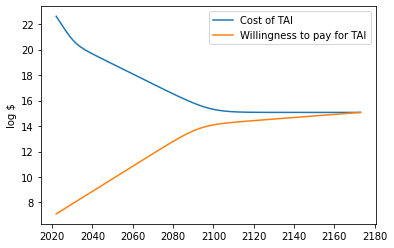

2173: ...Achieved aligned TAI (aligned via work, 2nd+ attempt), happy future! :D
-
-
-
-
############
## RUN 11 ##
############
Anchor debug:
-- Assume human brain in inference takes 14.5 log FLOP
-- Add 1.6 log FLOP for efficiency
-- Assume a transformative model takes 1.3 log FLOP compared to human
-- Assume a horizon length of 6.0
-- Assume a scaling exponent of 0.791
-- Assume FLOPs per param per sec of 1.9
-- 37.6 = 14.5 + 1.6 + 1.3 + 6.0 + 12 - 0.791 * 11.2 + 0.791 * (14.5 + 1.6 - 1.9)
-- 37.6 after Bayes update
-
### TAI TIMELINE VARIABLES ###
It takes 37.6 log FLOPs (~41 thousand decillion) for transformative capabilities.
Every 1.8 years algorithms get 2x better, with 1.6 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 3.4 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 1.3x per year to a max of 0.81% of GDP. G

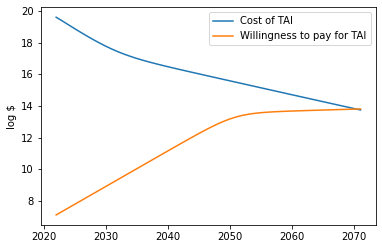

2071: ...XRISK from fully unaligned TAI (singleton) :(
...Singleton is catastrophic
-
-
-
-
############
## RUN 12 ##
############
Anchor debug:
-- Assume human brain in inference takes 12.3 log FLOP
-- Add 1.5 log FLOP for efficiency
-- Assume a transformative model takes -0.1 log FLOP compared to human
-- Assume a horizon length of 0
-- Assume a scaling exponent of 1.152
-- Assume FLOPs per param per sec of 1.4
-- 27.1 = 12.3 + 1.5 + -0.1 + 0 + 12 - 1.152 * 11.2 + 1.152 * (12.3 + 1.5 - 1.4)
-- 27.1 after Bayes update
-
### TAI TIMELINE VARIABLES ###
It takes 27.1 log FLOPs (~1 octillion) for transformative capabilities.
Every 2.1 years algorithms get 2x better, with 2.0 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 2.9 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 4.4x per year to a max of 0.81% of GDP. GDP grows 

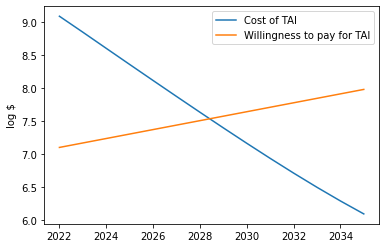

2035: ...XRISK from fully unaligned TAI (singleton) :(
...Singleton is catastrophic
-
-
-
-
############
## RUN 13 ##
############
Anchor debug:
-- Assume human brain in inference takes 12.4 log FLOP
-- Add 2.6 log FLOP for efficiency
-- Assume a transformative model takes 0.2 log FLOP compared to human
-- Assume a horizon length of 8.6
-- Assume a scaling exponent of 0.81
-- Assume FLOPs per param per sec of 2.3
-- 37.0 = 12.4 + 2.6 + 0.2 + 8.6 + 12 - 0.81 * 11.2 + 0.81 * (12.4 + 2.6 - 2.3)
-- 37.0 after Bayes update
-
### TAI TIMELINE VARIABLES ###
It takes 37.0 log FLOPs (~10 thousand decillion) for transformative capabilities.
Every 1.9 years algorithms get 2x better, with 4.0 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 2.8 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 3.5x per year to a max of 0.81% of GDP. G

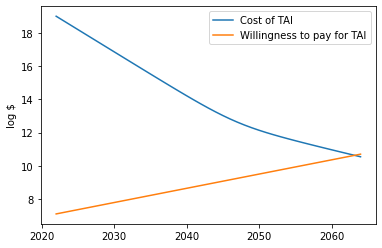

2064: ...Achieved aligned TAI (aligned via work, 2nd+ attempt), happy future! :D
-
-
-
-
############
## RUN 14 ##
############
Anchor debug:
-- Assume human brain in inference takes 10.5 log FLOP
-- Add 3.2 log FLOP for efficiency
-- Assume a transformative model takes -0.9 log FLOP compared to human
-- Assume a horizon length of 3.1
-- Assume a scaling exponent of 0.601
-- Assume FLOPs per param per sec of 1.8
-- 28.3 = 10.5 + 3.2 + -0.9 + 3.1 + 12 - 0.601 * 11.2 + 0.601 * (10.5 + 3.2 - 1.8)
-- 28.3 after Bayes update
-
### TAI TIMELINE VARIABLES ###
It takes 28.3 log FLOPs (~22 octillion) for transformative capabilities.
Every 2.1 years algorithms get 2x better, with 3.5 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 3.2 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 2.4x per year to a max of 0.81% of GDP. GDP grow

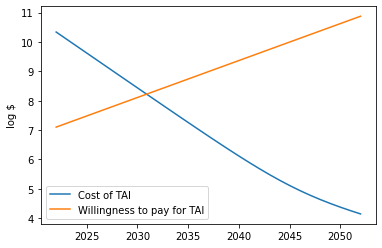

2052: ...Achieved aligned TAI (aligned via work, 2nd+ attempt), happy future! :D
-
-
-
-
############
## RUN 15 ##
############
Anchor debug:
-- Assume human brain in inference takes 17.6 log FLOP
-- Add 3.1 log FLOP for efficiency
-- Assume a transformative model takes -1.1 log FLOP compared to human
-- Assume a horizon length of 0
-- Assume a scaling exponent of 1.068
-- Assume FLOPs per param per sec of 1.4
-- 40.2 = 17.6 + 3.1 + -1.1 + 0 + 12 - 1.068 * 11.2 + 1.068 * (17.6 + 3.1 - 1.4)
-- 40.2 after Bayes update
-
### TAI TIMELINE VARIABLES ###
It takes 40.2 log FLOPs (~18 million decillion) for transformative capabilities.
Every 1.5 years algorithms get 2x better, with 4.9 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 3.8 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.7 log 2022$USD (~50 million) and this increases by 1.6x per year to a max of 0.81% of GDP. GDP 

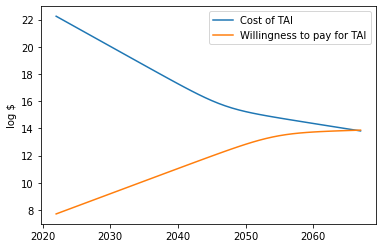

2067: ...XRISK from subtly unaligned TAI :(
-
-
-
-
############
## RUN 16 ##
############
Anchor debug:
-- Assume human brain in inference takes 11.5 log FLOP
-- Add 1.4 log FLOP for efficiency
-- Assume a transformative model takes -1.4 log FLOP compared to human
-- Assume a horizon length of 2.5
-- Assume a scaling exponent of 1.106
-- Assume FLOPs per param per sec of 1.6
-- 26.1 = 11.5 + 1.4 + -1.4 + 2.5 + 12 - 1.106 * 11.2 + 1.106 * (11.5 + 1.4 - 1.6)
-- 26.1 after Bayes update
-
### TAI TIMELINE VARIABLES ###
It takes 26.1 log FLOPs (~138 septillion) for transformative capabilities.
Every 1.9 years algorithms get 2x better, with 2.8 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 3.2 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 5.5x per year to a max of 0.81% of GDP. GDP grows at a rate of 1.03x per year.
If a

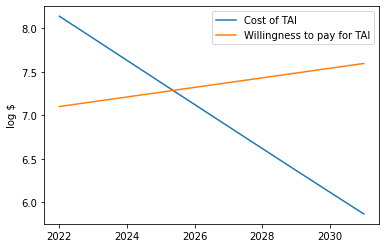

2031: ...XRISK from fully unaligned TAI (extinction) :(
-
-
-
-
############
## RUN 17 ##
############
Anchor debug:
-- Assume human brain in inference takes 11.4 log FLOP
-- Add 2.1 log FLOP for efficiency
-- Assume a transformative model takes -2.1 log FLOP compared to human
-- Assume a horizon length of 2.6
-- Assume a scaling exponent of 1.031
-- Assume FLOPs per param per sec of 1.7
-- 26.6 = 11.4 + 2.1 + -2.1 + 2.6 + 12 - 1.031 * 11.2 + 1.031 * (11.4 + 2.1 - 1.7)
-- 28.4 after Bayes update
-
### TAI TIMELINE VARIABLES ###
It takes 28.4 log FLOPs (~23 octillion) for transformative capabilities.
Every 2.3 years algorithms get 2x better, with 2.1 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 3.7 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 5.6x per year to a max of 0.81% of GDP. GDP grows at a rate of 1.025x per

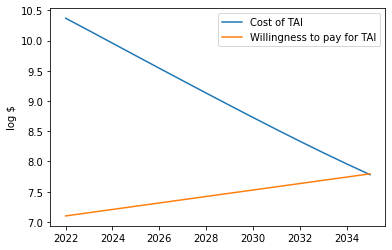

2035: ...XRISK from fully unaligned TAI (extinction) :(
-
-
-
-
############
## RUN 18 ##
############
Anchor debug:
-- Assume human brain in inference takes 17.2 log FLOP
-- Add 4.3 log FLOP for efficiency
-- Assume a transformative model takes 0.3 log FLOP compared to human
-- Assume a horizon length of 0.7
-- Assume a scaling exponent of 1.014
-- Assume FLOPs per param per sec of 1.9
-- 43.0 = 17.2 + 4.3 + 0.3 + 0.7 + 12 - 1.014 * 11.2 + 1.014 * (17.2 + 4.3 - 1.9)
-- 43.0 after Bayes update
-
### TAI TIMELINE VARIABLES ###
It takes 43.0 log FLOPs (~11 billion decillion) for transformative capabilities.
Every 1.7 years algorithms get 2x better, with 4.3 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 4.4 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 1.5x per year to a max of 0.81% of GDP. GDP grows at a rate of 1.02

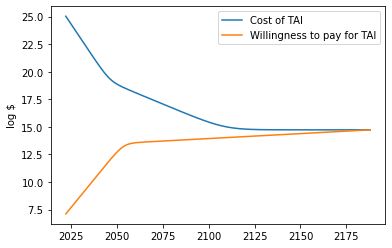

2188: ...XRISK from intentional misuse of TAI (singleton) :(
...Singleton is catastrophic
-
-
-
-
############
## RUN 19 ##
############
Anchor debug:
-- Assume human brain in inference takes 12.3 log FLOP
-- Add 2.3 log FLOP for efficiency
-- Assume a transformative model takes 0.3 log FLOP compared to human
-- Assume a horizon length of 0
-- Assume a scaling exponent of 0.72
-- Assume FLOPs per param per sec of 0.9
-- 28.6 = 12.3 + 2.3 + 0.3 + 0 + 12 - 0.72 * 11.2 + 0.72 * (12.3 + 2.3 - 0.9)
-- 28.6 after Bayes update
-
### TAI TIMELINE VARIABLES ###
It takes 28.6 log FLOPs (~37 octillion) for transformative capabilities.
Every 2.2 years algorithms get 2x better, with 2.3 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 3.8 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.2 log 2022$USD (~17 million) and this increases by 2.5x per year to a max of 0.81% of GDP. GDP grow

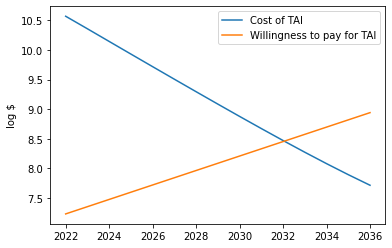

2036: ...Achieved aligned TAI (aligned via work, 2nd+ attempt), happy future! :D
-
-
-
-
############
## RUN 20 ##
############
Anchor debug:
-- Assume human brain in inference takes 9.7 log FLOP
-- Add 1.9 log FLOP for efficiency
-- Assume a transformative model takes -0.7 log FLOP compared to human
-- Assume a horizon length of 0
-- Assume a scaling exponent of 0.562
-- Assume FLOPs per param per sec of 1.7
-- 22.3 = 9.7 + 1.9 + -0.7 + 0 + 12 - 0.562 * 11.2 + 0.562 * (9.7 + 1.9 - 1.7)
-- 24.5 after Bayes update
-
### TAI TIMELINE VARIABLES ###
It takes 24.5 log FLOPs (~3 septillion) for transformative capabilities.
Every 2.7 years algorithms get 2x better, with 1.9 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 2.3 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 8.5 log 2022$USD (~284 million) and this increases by 3.7x per year to a max of 0.81% of GDP. GDP grows at a

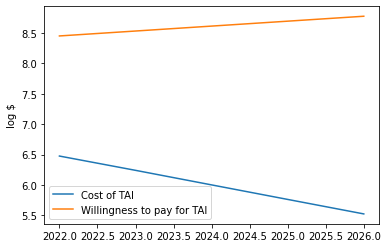

2026: ...XRISK from fully unaligned TAI (extinction) :(
-
-
-
-
############
## RUN 21 ##
############
Anchor debug:
-- Assume human brain in inference takes 15.6 log FLOP
-- Add 2.4 log FLOP for efficiency
-- Assume a transformative model takes -1.5 log FLOP compared to human
-- Assume a horizon length of 1.7
-- Assume a scaling exponent of 0.768
-- Assume FLOPs per param per sec of 1.1
-- 34.6 = 15.6 + 2.4 + -1.5 + 1.7 + 12 - 0.768 * 11.2 + 0.768 * (15.6 + 2.4 - 1.1)
-- 34.6 after Bayes update
-
### TAI TIMELINE VARIABLES ###
It takes 34.6 log FLOPs (~41 decillion) for transformative capabilities.
Every 1.2 years algorithms get 2x better, with 3.4 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 3.5 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 2.8x per year to a max of 0.81% of GDP. GDP grows at a rate of 1.031x per

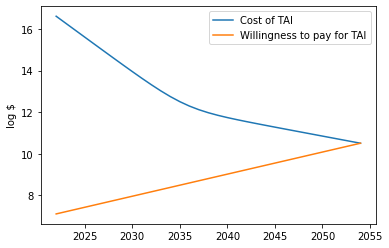

2054: ...Achieved aligned TAI (aligned via work, 2nd+ attempt), happy future! :D
-
-
-
-
############
## RUN 22 ##
############
Anchor debug:
-- Assume human brain in inference takes 22.7 log FLOP
-- Add 0 log FLOP for efficiency
-- Assume a transformative model takes -0.9 log FLOP compared to human
-- Assume a horizon length of 8.7
-- Assume a scaling exponent of 1.214
-- Assume FLOPs per param per sec of 1.7
-- 54.4 = 22.7 + 0 + -0.9 + 8.7 + 12 - 1.214 * 11.2 + 1.214 * (22.7 + 0 - 1.7)
-- 54.4 after Bayes update
-
### TAI TIMELINE VARIABLES ###
It takes 54.4 log FLOPs (~3 sextillion decillion) for transformative capabilities.
Every 1.4 years algorithms get 2x better, with 0 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 2.9 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 1.3x per year to a max of 0.81% of GDP. GDP gr

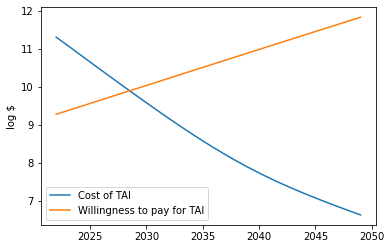

2049: ...XRISK from fully unaligned TAI (singleton) :(
...Singleton is catastrophic
-
-
-
-
############
## RUN 24 ##
############
Anchor debug:
-- Assume human brain in inference takes 12.6 log FLOP
-- Add 0 log FLOP for efficiency
-- Assume a transformative model takes -0.1 log FLOP compared to human
-- Assume a horizon length of 2.9
-- Assume a scaling exponent of 0.898
-- Assume FLOPs per param per sec of 1.0
-- 27.8 = 12.6 + 0 + -0.1 + 2.9 + 12 - 0.898 * 11.2 + 0.898 * (12.6 + 0 - 1.0)
-- 27.8 after Bayes update
-
### TAI TIMELINE VARIABLES ###
It takes 27.8 log FLOPs (~6 octillion) for transformative capabilities.
Every 1.5 years algorithms get 2x better, with 0 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 3.7 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 5.4x per year to a max of 0.81% of GDP. GDP grows at a

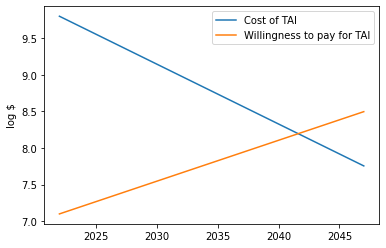

2047: ...Achieved aligned TAI (aligned via work, 2nd+ attempt), happy future! :D
-
-
-
-
############
## RUN 25 ##
############
Anchor debug:
-- Assume human brain in inference takes 15.4 log FLOP
-- Add 2.2 log FLOP for efficiency
-- Assume a transformative model takes -0.7 log FLOP compared to human
-- Assume a horizon length of 9.5
-- Assume a scaling exponent of 0.914
-- Assume FLOPs per param per sec of 1.8
-- 42.6 = 15.4 + 2.2 + -0.7 + 9.5 + 12 - 0.914 * 11.2 + 0.914 * (15.4 + 2.2 - 1.8)
-- 42.6 after Bayes update
-
### TAI TIMELINE VARIABLES ###
It takes 42.6 log FLOPs (~4 billion decillion) for transformative capabilities.
Every 1.0 years algorithms get 2x better, with 3.0 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 2.8 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 8.6 log 2022$USD (~362 million) and this increases by 4.9x per year to a max of 0.81% of GDP. 

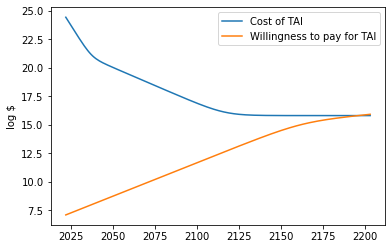

2203: ...Tool TAI made
...Boring future
-
-
-
-
############
## RUN 27 ##
############
Anchor debug:
-- Assume human brain in inference takes 16.5 log FLOP
-- Add 2.6 log FLOP for efficiency
-- Assume a transformative model takes -0.1 log FLOP compared to human
-- Assume a horizon length of 0
-- Assume a scaling exponent of 1.138
-- Assume FLOPs per param per sec of 1.6
-- 38.2 = 16.5 + 2.6 + -0.1 + 0 + 12 - 1.138 * 11.2 + 1.138 * (16.5 + 2.6 - 1.6)
-- 38.2 after Bayes update
-
### TAI TIMELINE VARIABLES ###
It takes 38.2 log FLOPs (~160 thousand decillion) for transformative capabilities.
Every 1.4 years algorithms get 2x better, with 3.5 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 4.0 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 8.5 log 2022$USD (~289 million) and this increases by 4.0x per year to a max of 0.81% of GDP. GDP grows at a rate of 1.02x per year.
If 

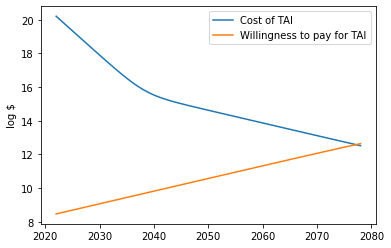

2078: ...Achieved aligned TAI (aligned via work, 2nd+ attempt), happy future! :D
-
-
-
-
############
## RUN 28 ##
############
Anchor debug:
-- Assume human brain in inference takes 14.9 log FLOP
-- Add 2.5 log FLOP for efficiency
-- Assume a transformative model takes 1.0 log FLOP compared to human
-- Assume a horizon length of 4.4
-- Assume a scaling exponent of 0.793
-- Assume FLOPs per param per sec of 1.4
-- 38.6 = 14.9 + 2.5 + 1.0 + 4.4 + 12 - 0.793 * 11.2 + 0.793 * (14.9 + 2.5 - 1.4)
-- 38.6 after Bayes update
-
### TAI TIMELINE VARIABLES ###
It takes 38.6 log FLOPs (~434 thousand decillion) for transformative capabilities.
Every 1.4 years algorithms get 2x better, with 3.3 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 2.8 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.4 log 2022$USD (~27 million) and this increases by 3.5x per year to a max of 0.81% of GDP. 

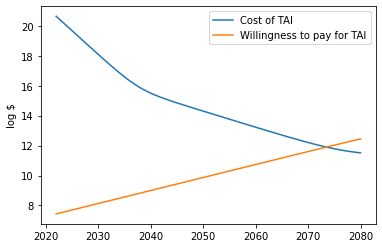

2080: ...XRISK from fully unaligned TAI (singleton) :(
...Singleton is catastrophic
-
-
-
-
############
## RUN 29 ##
############
Anchor debug:
-- Assume human brain in inference takes 19.3 log FLOP
-- Add 1.5 log FLOP for efficiency
-- Assume a transformative model takes -0.6 log FLOP compared to human
-- Assume a horizon length of 9.9
-- Assume a scaling exponent of 1.143
-- Assume FLOPs per param per sec of 0.7
-- 52.3 = 19.3 + 1.5 + -0.6 + 9.9 + 12 - 1.143 * 11.2 + 1.143 * (19.3 + 1.5 - 0.7)
-- 52.3 after Bayes update
-
### TAI TIMELINE VARIABLES ###
It takes 52.3 log FLOPs (~21 quintillion decillion) for transformative capabilities.
Every 2.1 years algorithms get 2x better, with 1.5 log reductions possible.
FLOPs start at a cost of 18.0 log FLOPs (~1 quintillion) per 2022$USD. Every 2.6 years they get 2x cheaper, to a maximum of 24.0 log FLOPs (~1 septillion) per 2022$USD.
We are willing to pay 7.1 log 2022$USD (~13 million) and this increases by 4.6x per year to a max of 0.81% o

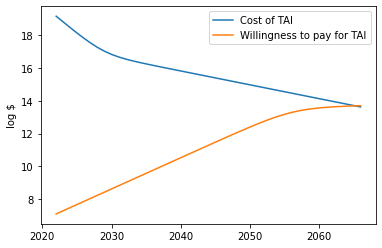

2066: ...Achieved aligned TAI (aligned via work, 2nd+ attempt), happy future! :D
-
-


In [26]:
for i in range(30):
    print('-')
    print('-')
    print('############')
    print('## RUN {} ##'.format(i + 1))
    print('############')
    define_event(verbose=True)

In [27]:
collectors = bayes.bayesnet(define_event,
                            find=lambda e: e['collectors'],
                            raw=True, verbose=True, n=RUNS)

Checking cache...
Generating Bayes net...


100%|██████████████████████████████████████████████████████████| 10000/10000 [01:08<00:00, 145.89it/s]

...Generated
Caching...
...Cached


In [28]:
print('0. World State At Year')
for y_c in [2030, 2050, 2070, 2100, 2200]:
    print('## {} ##'.format(y_c)) 
    pprint(print_states([c[y_c]['category'] for c in collectors]))
    print('-')
    print('-')

0. World State At Year
## 2030 ##
[('boring', 94.56),
 ('xrisk_full_unaligned_tai_singleton', 2.46),
 ('aligned_tai', 1.24),
 ('xrisk_full_unaligned_tai_extinction', 1.06),
 ('xrisk_tai_misuse', 0.36),
 ('xrisk_subtly_unaligned_tai', 0.3),
 ('xrisk_unknown_unknown', 0.02),
 ('xrisk_nanotech', 0.0),
 ('xrisk_nukes_war', 0.0),
 ('xrisk_nukes_accident', 0.0),
 ('xrisk_bio_accident', 0.0),
 ('xrisk_bio_war', 0.0),
 ('xrisk_bio_nonstate', 0.0),
 ('xrisk_supervolcano', 0.0)]
-
-
## 2050 ##
[('boring', 66.54),
 ('aligned_tai', 15.07),
 ('xrisk_full_unaligned_tai_singleton', 8.61),
 ('xrisk_full_unaligned_tai_extinction', 4.24),
 ('xrisk_tai_misuse', 2.77),
 ('xrisk_subtly_unaligned_tai', 2.72),
 ('xrisk_unknown_unknown', 0.04),
 ('xrisk_nanotech', 0.01),
 ('xrisk_nukes_war', 0.0),
 ('xrisk_nukes_accident', 0.0),
 ('xrisk_bio_accident', 0.0),
 ('xrisk_bio_war', 0.0),
 ('xrisk_bio_nonstate', 0.0),
 ('xrisk_supervolcano', 0.0)]
-
-
## 2070 ##
[('boring', 49.75),
 ('aligned_tai', 24.69),
 ('xrisk

In [29]:
print('0B. Catastrophe States At Year')

def print_catastrophe(catastrophes):
    c = Counter([' '.join(sorted(c)) for c in catastrophes])
    c = dict([(k, round(v / RUNS * 100, 2)) for k, v in c.items()])
    c = sorted(c.items(), key=lambda x: x[1], reverse=True)
    c = [c_ for c_ in c if c_[1] >= 0.1]
    return c

for y_c in [2030, 2050, 2070, 2100, 2200]:
    print('## {} ##'.format(y_c))  
    pprint(print_catastrophe([c[y_c]['catastrophe'] for c in collectors]))
    print('-')
    print('-')
    
# TODO: Small chance that war produces non-nukes catastrophe
# TODO: Chance of getting nukes-based singleton via secure first strike

0B. Catastrophe States At Year
## 2030 ##
[('', 94.92),
 ('xrisk_full_unaligned_tai_singleton', 1.89),
 ('xrisk_full_unaligned_tai_extinction', 1.06),
 ('nukes_accident', 0.85),
 ('engineered_pathogen', 0.48),
 ('xrisk_tai_misuse', 0.32),
 ('natural_pathogen', 0.23),
 ('averting_misaligned_tai', 0.11)]
-
-
## 2050 ##
[('', 79.5),
 ('xrisk_full_unaligned_tai_singleton', 6.63),
 ('xrisk_full_unaligned_tai_extinction', 4.08),
 ('nukes_accident', 3.39),
 ('xrisk_tai_misuse', 2.03),
 ('engineered_pathogen', 1.29),
 ('natural_pathogen', 0.65),
 ('nukes_war', 0.43),
 ('averting_misaligned_tai', 0.38),
 ('nukes_accident nukes_accident', 0.32),
 ('nukes_accident nukes_war', 0.15),
 ('nukes_accident xrisk_tai_misuse', 0.15),
 ('nukes_accident xrisk_full_unaligned_tai_singleton', 0.13),
 ('averting_intentional_tai', 0.12),
 ('engineered_pathogen nukes_accident', 0.1),
 ('nukes_accident xrisk_full_unaligned_tai_extinction', 0.1)]
-
-
## 2070 ##
[('', 71.1),
 ('xrisk_full_unaligned_tai_singleton', 

In [30]:
print('0C. *First* Catastrophe State At Year')

def print_catastrophe_first(catastrophes):
    c = Counter([c[0] if len(c) > 0 else '' for c in catastrophes])
    c = dict([(k, round(v / RUNS * 100, 2)) for k, v in c.items()])
    c = sorted(c.items(), key=lambda x: x[1], reverse=True)
    c = [c_ for c_ in c if c_[1] >= 0.1]
    return c

for y_c in [2030, 2050, 2070, 2100, 2200]:
    print('## {} ##'.format(y_c))  
    pprint(print_catastrophe_first([c[y_c]['catastrophe'] for c in collectors]))
    print('-')
    print('-')
    
# TODO: Print world state with x-risk or catastrophe

0C. *First* Catastrophe State At Year
## 2030 ##
[('', 94.92),
 ('xrisk_full_unaligned_tai_singleton', 1.89),
 ('xrisk_full_unaligned_tai_extinction', 1.06),
 ('nukes_accident', 0.9),
 ('engineered_pathogen', 0.49),
 ('xrisk_tai_misuse', 0.32),
 ('natural_pathogen', 0.23),
 ('averting_misaligned_tai', 0.11)]
-
-
## 2050 ##
[('', 79.5),
 ('xrisk_full_unaligned_tai_singleton', 6.63),
 ('nukes_accident', 4.33),
 ('xrisk_full_unaligned_tai_extinction', 4.08),
 ('xrisk_tai_misuse', 2.03),
 ('engineered_pathogen', 1.52),
 ('natural_pathogen', 0.73),
 ('nukes_war', 0.54),
 ('averting_misaligned_tai', 0.43),
 ('averting_intentional_tai', 0.12)]
-
-
## 2070 ##
[('', 71.1),
 ('xrisk_full_unaligned_tai_singleton', 7.98),
 ('nukes_accident', 7.72),
 ('xrisk_full_unaligned_tai_extinction', 5.06),
 ('xrisk_tai_misuse', 3.15),
 ('engineered_pathogen', 2.22),
 ('natural_pathogen', 1.0),
 ('nukes_war', 0.94),
 ('averting_misaligned_tai', 0.53),
 ('averting_intentional_tai', 0.16)]
-
-
## 2100 ##
[('', 

In [31]:
print('1. Genetically Engineered Pathogen Risk* (1%+ death)')
for y_c in [2030, 2050, 2100]:
    r = bayes.bayesnet(define_event,
                       find=lambda e: e['collectors'][y_c]['engineered_pathogen'],
                       n=RUNS)
    print('{} - {}%'.format(y_c, round(r * 100, 2)))
    

1. Genetically Engineered Pathogen Risk* (1%+ death)
2030 - 0.0%
2050 - 0.0%
2100 - 0.0%


In [32]:
print('2. Non-Genetically Engineered Pathogen Risk* (1%+ death)')
for y_c in [2030, 2050, 2100]:
    r = bayes.bayesnet(define_event,
                       find=lambda e: e['collectors'][y_c]['natural_pathogen'],
                       n=RUNS)
    print('{} - {}%'.format(y_c, round(r * 100, 2)))    

2. Non-Genetically Engineered Pathogen Risk* (1%+ death)
2030 - 0.36%
2050 - 1.11%
2100 - 1.83%


In [33]:
print('2B. Pathogen Catastrophic Risk (10%+ death)')
for y_c in [2030, 2050, 2100]:
    r = bayes.bayesnet(define_event,
                       find=lambda e: 'pathogen' in ' '.join(e['collectors'][y_c]['catastrophe']),
                       n=RUNS)
    print('{} - {}%'.format(y_c, round(r * 100, 2)))

# TODO: Percentages for different sources of pathogen


2B. Pathogen Catastrophic Risk (10%+ death)
2030 - 0.73%
2050 - 2.31%
2100 - 4.81%


In [34]:
print('2C. Pathogen Extinction Risk')
for y_c in [2030, 2050, 2100]:
    r = bayes.bayesnet(define_event,
                       find=lambda e: 'xrisk_bio' in e['collectors'][y_c]['category'],
                       n=RUNS)
    print('{} - {}%'.format(y_c, round(r * 100, 3)))

# TODO: Percentages for different sources of pathogen
    

2C. Pathogen Extinction Risk
2030 - 0.0%
2050 - 0.0%
2100 - 0.0%


In [35]:
print('3. AI Catastrophic Risk* (10%+ death)')
for y_c in [2030, 2050, 2100]:
    r = bayes.bayesnet(define_event,
                       find=lambda e: 'tai' in ' '.join(e['collectors'][y_c]['catastrophe']),
                       n=RUNS)
    print('{} - {}%'.format(y_c, round(r * 100, 2)))

3. AI Catastrophic Risk* (10%+ death)
2030 - 3.43%
2050 - 13.91%
2100 - 22.95%


In [36]:
print('4. AI Extinction Risk*')
for y_c in [2030, 2050, 2100]:
    r = bayes.bayesnet(define_event,
                       find=lambda e: e['collectors'][y_c]['category'] == 'xrisk_full_unaligned_tai_extinction',
                       n=RUNS)
    print('{} - {}%'.format(y_c, round(r * 100, 2)))


4. AI Extinction Risk*
2030 - 1.06%
2050 - 4.24%
2100 - 6.72%


In [37]:
print('4B. AI X-Risk')

def find(y_c, category):
    return bayes.bayesnet(define_event,
                          find=lambda e: e['collectors'][y_c]['category'] == category,
                          n=RUNS)

for y_c in [2024, 2030, 2050, 2070, 2100, 2200]:
    extinction = find(y_c, 'xrisk_full_unaligned_tai_extinction')
    singleton = find(y_c, 'xrisk_full_unaligned_tai_singleton')
    subtle_misalignment = find(y_c, 'xrisk_subtly_unaligned_tai')
    misuse = find(y_c, 'xrisk_tai_misuse')
    out = '{} - {}% (Extinction: {}%, Bad TAI singleton: {}%, Subtly misaligned singleton: {}%, Misuse singleton: {}%)'
    print(out.format(y_c,
                     round((extinction + singleton + subtle_misalignment + misuse) * 100, 1),
                     round(extinction * 100, 1),
                     round(singleton * 100, 1),
                     round(subtle_misalignment * 100, 1),
                     round(misuse * 100, 1)))


4B. AI X-Risk
2024 - 0.5% (Extinction: 0.1%, Bad TAI singleton: 0.3%, Subtly misaligned singleton: 0.0%, Misuse singleton: 0.0%)
2030 - 4.2% (Extinction: 1.1%, Bad TAI singleton: 2.5%, Subtly misaligned singleton: 0.3%, Misuse singleton: 0.4%)
2050 - 18.3% (Extinction: 4.2%, Bad TAI singleton: 8.6%, Subtly misaligned singleton: 2.7%, Misuse singleton: 2.8%)
2070 - 25.5% (Extinction: 5.5%, Bad TAI singleton: 10.8%, Subtly misaligned singleton: 4.5%, Misuse singleton: 4.7%)
2100 - 31.9% (Extinction: 6.7%, Bad TAI singleton: 12.7%, Subtly misaligned singleton: 5.9%, Misuse singleton: 6.6%)
2200 - 36.5% (Extinction: 7.6%, Bad TAI singleton: 14.2%, Subtly misaligned singleton: 6.7%, Misuse singleton: 8.1%)


In [38]:
# “P(misalignment x-risk|AGI)”: Conditional on AGI being developed by 2070, humanity will go extinct or
# drastically curtail its future potential due to loss of control of AGI

print('4C. AI X-Risk conditional on AGI by 2070')

def find(y_c, category):
    return bayes.bayesnet(define_event,
                          find=lambda e: e['collectors'][y_c]['category'] == category,
                          conditional_on=lambda e: e['final_state']['tai_year'] <= 2070 if e['final_state']['tai_year'] is not None else False,
                          n=RUNS)

for y_c in [2070, 2100]:
    extinction = find(y_c, 'xrisk_full_unaligned_tai_extinction')
    singleton = find(y_c, 'xrisk_full_unaligned_tai_singleton')
    subtle_misalignment = find(y_c, 'xrisk_subtly_unaligned_tai')
    misuse = find(y_c, 'xrisk_tai_misuse')
    out = '{} - {}% (Extinction: {}%, Bad TAI singleton: {}%, Subtly misaligned singleton: {}%, Misuse singleton: {}%)'
    print(out.format(y_c,
                     round((extinction + singleton + subtle_misalignment + misuse) * 100, 1),
                     round(extinction * 100, 1),
                     round(singleton * 100, 1),
                     round(subtle_misalignment * 100, 1),
                     round(misuse * 100, 1)))


4C. AI X-Risk conditional on AGI by 2070
2070 - 44.2% (Extinction: 9.5%, Bad TAI singleton: 18.7%, Subtly misaligned singleton: 7.8%, Misuse singleton: 8.2%)
2100 - 44.2% (Extinction: 9.5%, Bad TAI singleton: 18.7%, Subtly misaligned singleton: 7.8%, Misuse singleton: 8.2%)


In [39]:
print('4D. Aligned TAI')
for y_c in [2024, 2030, 2050, 2070, 2100, 2200]:
    r = bayes.bayesnet(define_event,
                       find=lambda e: e['collectors'][y_c]['category'] == 'aligned_tai',
                       n=RUNS)
    print('{} - {}%'.format(y_c, round(r * 100, 2)))
    

4D. Aligned TAI
2024 - 0.07%
2030 - 1.24%
2050 - 15.07%
2070 - 24.69%
2100 - 32.08%
2200 - 36.09%


In [40]:
print('4E. When TAI?')
yrs = bayes.bayesnet(define_event,
                     find=lambda e: e['final_state']['tai_year'],
                     raw=True,
                     n=RUNS)
sq.get_percentiles([2223 if yr is None else yr for yr in yrs])

4E. When TAI?


{1: 2025.0,
 5: 2029.0,
 10: 2033.0,
 20: 2039.0,
 30: 2044.0,
 40: 2052.0,
 50: 2061.0,
 60: 2074.0,
 70: 2091.0,
 80: 2134.0,
 90: 2223.0,
 95: 2223.0,
 99: 2223.0}

In [41]:
print('5. Nuclear Catastrophic Risk* (10%+ death)')
for y_c in [2030, 2050, 2100]:
    r = bayes.bayesnet(define_event,
                       find=lambda e: 'nukes' in ' '.join(e['collectors'][y_c]['catastrophe']),
                       n=RUNS)
    print('{} - {}%'.format(y_c, round(r * 100, 2)))
    

5. Nuclear Catastrophic Risk* (10%+ death)
2030 - 0.94%
2050 - 5.04%
2100 - 14.64%


In [42]:
print('6. Nuclear Extinction Risk*')

def find(y_c, category):
    return bayes.bayesnet(define_event,
                          find=lambda e: e['collectors'][y_c]['category'] == category,
                          n=RUNS)

for y_c in [2030, 2050, 2100, 2200]:
    war = find(y_c, 'xrisk_nukes_war')
    accident = find(y_c, 'xrisk_nukes_accident')
    print('{} - {}% (war: {}%, accident: {}%)'.format(y_c,
                                                      round((war + accident) * 100, 3),
                                                      round(war * 100, 3),
                                                      round(accident * 100, 3)))
    

6. Nuclear Extinction Risk*
2030 - 0.0% (war: 0.0%, accident: 0.0%)
2050 - 0.0% (war: 0.0%, accident: 0.0%)
2100 - 0.02% (war: 0.01%, accident: 0.01%)
2200 - 0.14% (war: 0.01%, accident: 0.13%)


In [43]:
print('7. Non-Anthropogenic Catastrophic Risk* (10%+ death)')

for y_c in [2030, 2050, 2100]:
    r = bayes.bayesnet(define_event,
                       find=lambda e: 'supervolcano' in ' '.join(e['collectors'][y_c]['catastrophe']),
                       n=RUNS)
    print('{} - {}%'.format(y_c, round(r * 100, 3)))
    
# NOTE: All other sources < 0.01%


7. Non-Anthropogenic Catastrophic Risk* (10%+ death)
2030 - 0.01%
2050 - 0.04%
2100 - 0.09%


In [44]:
print('8. Non-Anthropogenic Extinction Risk*')

for y_c in [2030, 2050, 2100]:
    r = bayes.bayesnet(define_event,
                       find=lambda e: e['collectors'][y_c]['category'] == 'xrisk_supervolcano',
                       n=RUNS)
    print('{} - {}%'.format(y_c, round(r * 100, 3)))

# NOTE: All other sources < 0.01%


8. Non-Anthropogenic Extinction Risk*
2030 - 0.0%
2050 - 0.0%
2100 - 0.0%


In [45]:
print('9. Total Catastrophic Risk* (10%+ death)')

for y_c in [2030, 2050, 2100]:
    r = bayes.bayesnet(define_event,
                       find=lambda e: e['collectors'][y_c]['catastrophe'] != [],
                       n=RUNS)
    print('{} - {}%'.format(y_c, round(r * 100, 2)))
    

9. Total Catastrophic Risk* (10%+ death)
2030 - 5.08%
2050 - 20.5%
2100 - 37.79%


In [46]:
print('10. Total Extinction Risk*')
for y_c in [2030, 2050, 2100]:
    r = bayes.bayesnet(define_event,
                       find=lambda e: e['collectors'][y_c]['category'] in extinctions,
                       n=RUNS)
    print('{} - {}%'.format(y_c, round(r * 100, 2)))
    
        # TODO: Refine singleton risks
        # TODO: Add in risk of transitioning from humans
        

10. Total Extinction Risk*
2030 - 1.08%
2050 - 4.29%
2100 - 6.84%


In [47]:
print('10B. Total X-Risk (including non-extinction x-risks and excluding successful tranisition-based extinctions)')

def find(y_c, category):
    return bayes.bayesnet(define_event,
                          find=lambda e: ('xrisk' in e['collectors'][y_c]['category']) and (category in e['collectors'][y_c]['category']),
                          n=RUNS)

for y_c in [2024, 2030, 2050, 2070, 2100, 2200]:
    ai = find(y_c, 'tai')
    nukes = find(y_c, 'nukes')
    unknown = find(y_c, 'unknown')
    nano = find(y_c, 'nanotech')
    natural = find(y_c, 'supervolcano')
    bio = find(y_c, 'bio')

    out = '{} - {}% (AI: {}%, Nukes: {}%, Bio: {}%, Nano: {}%, Natural: {}%, Other: {}%)'
    print(out.format(y_c,
                     round((ai + nukes + bio + nano + unknown) * 100, 2),
                     round(ai * 100, 2),
                     round(nukes * 100, 3),
                     round(bio * 100, 3),
                     round(nano * 100, 3),
                     round(natural * 100, 3),
                     round(unknown * 100, 3)))

# TODO: Non-AI singletons


10B. Total X-Risk (including non-extinction x-risks and excluding successful tranisition-based extinctions)
2024 - 0.48% (AI: 0.47%, Nukes: 0.0%, Bio: 0.0%, Nano: 0.0%, Natural: 0.0%, Other: 0.01%)
2030 - 4.2% (AI: 4.18%, Nukes: 0.0%, Bio: 0.0%, Nano: 0.0%, Natural: 0.0%, Other: 0.02%)
2050 - 18.39% (AI: 18.34%, Nukes: 0.0%, Bio: 0.0%, Nano: 0.01%, Natural: 0.0%, Other: 0.04%)
2070 - 25.56% (AI: 25.47%, Nukes: 0.01%, Bio: 0.0%, Nano: 0.01%, Natural: 0.0%, Other: 0.07%)
2100 - 32.0% (AI: 31.88%, Nukes: 0.02%, Bio: 0.0%, Nano: 0.01%, Natural: 0.0%, Other: 0.09%)
2200 - 36.94% (AI: 36.54%, Nukes: 0.14%, Bio: 0.0%, Nano: 0.14%, Natural: 0.01%, Other: 0.12%)


In [48]:
print('10C. Total X-Risk or catastrophe')

for y_c in [2024, 2030, 2050, 2070, 2100, 2200]:
    r = bayes.bayesnet(define_event,
                       find=lambda e: 'xrisk' in e['collectors'][y_c]['category'] or e['collectors'][y_c]['catastrophe'] != [],
                       n=RUNS)
    print('{} - {}%'.format(y_c, round(r * 100, 2)))

# TODO: Non-AI singletons


10C. Total X-Risk or catastrophe
2024 - 1.1%
2030 - 5.93%
2050 - 25.3%
2070 - 36.02%
2100 - 46.53%
2200 - 58.56%


In [49]:
print('10D. Total X-Risk AND catastrophe')

for y_c in [2024, 2030, 2050, 2070, 2100, 2200]:
    r = bayes.bayesnet(define_event,
                       find=lambda e: 'xrisk' in e['collectors'][y_c]['category'] and e['collectors'][y_c]['catastrophe'] != [],
                       n=RUNS)
    print('{} - {}%'.format(y_c, round(r * 100, 2)))

# TODO: Non-AI singletons


10D. Total X-Risk AND catastrophe
2024 - 0.4%
2030 - 3.35%
2050 - 13.59%
2070 - 18.44%
2100 - 23.26%
2200 - 27.38%


In [50]:
print('11. Year of Extinction*')
rs = bayes.bayesnet(define_event,
                    find=lambda e: (e['final_state']['category'], e['final_state']['final_year']),
                    raw=True,
                    n=RUNS)
extinction_years = [r[1] if r[0] in extinctions else 100000 for r in rs]
pprint(sq.get_percentiles(extinction_years, [5, 25, 50, 75, 95]))


11. Year of Extinction*
{5: 2060.95, 25: 100000.0, 50: 100000.0, 75: 100000.0, 95: 100000.0}


In [51]:
print('12. Future Human Births*')
pop_per_year = sq.lognorm(90*K, 1*B)
populations = [round((y - CURRENT_YEAR) * sq.sample(pop_per_year), 0) for y in extinction_years]
sq.get_log_percentiles(populations, [5, 25, 50, 75, 95])


12. Future Human Births*


{5: '10^8.6', 25: '10^10.9', 50: '10^11.8', 75: '10^12.7', 95: '10^13.9'}

In [52]:
print('13. Non-Coronavirus mRNA Vaccine*')

n_in_trials_2024 = sq.lognorm(36000, 36000*3)
n_in_scaled_vaccine = sq.lognorm(2*M, 2*B)
p_scaled_vaccine_by_2024 = 0.03

n_in_trials_2030 = sq.lognorm(108*K, 360*K)
p_scaled_vaccine_by_2030 = 0.1

p_aligned_tai_by_2024 = bayes.bayesnet(define_event,
                                       find=lambda e: e['collectors'][2024]['category'] == 'aligned_tai',
                                       n=RUNS)
p_xrisk_by_2024 = 1 - bayes.bayesnet(define_event,
                                     find=lambda e: e['collectors'][2024]['category'] == 'boring',
                                     n=RUNS) - p_aligned_tai_by_2024


def sim_2024():
    n = sq.sample(n_in_trials_2024)
    if sq.event_occurs(p_aligned_tai_by_2024):
        return n
    elif sq.event_occurs(p_xrisk_by_2024):
        return n / 3
    elif sq.event_occurs(p_scaled_vaccine_by_2024):
        return n + sq.sample(n_in_scaled_vaccine)
    else:
        return n
    # TODO: Delay for catastrophic risks?
    
    
p_aligned_tai_by_2030 = bayes.bayesnet(define_event,
                                       find=lambda e: e['collectors'][2030]['category'] == 'aligned_tai',
                                       n=RUNS)
p_xrisk_by_2030 = 1 - bayes.bayesnet(define_event,
                                     find=lambda e: e['collectors'][2030]['category'] == 'boring',
                                     n=RUNS) - p_aligned_tai_by_2030

def sim_2030(): # TODO: DRY
    n = sq.sample(n_in_trials_2030)
    if sq.event_occurs(p_aligned_tai_by_2030):
        return n
    elif sq.event_occurs(p_xrisk_by_2030):
        return n / 3
    elif sq.event_occurs(p_scaled_vaccine_by_2030):
        return n + sq.sample(n_in_scaled_vaccine)
    else:
        return n
    # TODO: Delay for catastrophic risks?


print('## 2024 ##')
pprint(sq.get_percentiles([sim_2024() for _ in range(5000)], [5, 25, 50, 75, 95], digits=0))

print('## 2030 ##')
pprint(sq.get_percentiles([sim_2030() for _ in range(5000)], [5, 25, 50, 75, 95], digits=0))


13. Non-Coronavirus mRNA Vaccine*
## 2024 ##
{5: 35549.0, 25: 50166.0, 50: 62704.0, 75: 79618.0, 95: 124639.0}
## 2030 ##
{5: 94180.0, 25: 153576.0, 50: 203957.0, 75: 279012.0, 95: 58486316.0}


In [53]:
print('31. Nuclear Weapon Use')
for y_c in [2024, 2030]:
    r = bayes.bayesnet(define_event,
                       find=lambda e: e['collectors'][y_c]['nuclear_weapon_used'],
                       n=RUNS)
    print('{} - {}%'.format(y_c, round(r * 100, 2)))
    

31. Nuclear Weapon Use
2024 - 5.72%
2030 - 16.89%


In [54]:
print('53. GWP >15% by 2100?')
bayes.bayesnet(define_event,
               find=lambda e: (e['final_state']['category'] == 'aligned_tai' and
                              (False if isinstance(e['final_state']['final_year'], str) else e['final_state']['final_year'] <= 2100)),
               n=RUNS) * 0.7 * 0.9


53. GWP >15% by 2100?


0.20210399999999995

In [55]:
print('53. Year GWP >15% if by 2100')
bayes.bayesnet(define_event,
               find=lambda e: e['final_state']['final_year'],
               conditional_on=lambda e: (e['final_state']['category'] == 'aligned_tai' and
                                         (False if isinstance(e['final_state']['final_year'], str) else e['final_state']['final_year'] <= 2100)),
               reduce_fn=lambda y: sq.get_percentiles(y, [95, 75, 50, 25, 5]),
               n=RUNS)


53. Year GWP >15% if by 2100


{95: 2090.6499999999996, 75: 2069.0, 50: 2052.0, 25: 2042.0, 5: 2032.0}

In [56]:
print('55. Space Colony*')

def p_space_colony_if_boring(year):
    return 1 - (0.998 ** year)

p_space_colony_if_aligned_tai = 0.1

for y_c in [2030, 2050, 2100]:
    p_aligned_tai = bayes.bayesnet(define_event,
                                   find=lambda e: e['collectors'][y_c]['category'] == 'aligned_tai',
                                   n=RUNS)
    p_boring = bayes.bayesnet(define_event,
                              find=lambda e: e['collectors'][y_c]['category'] == 'boring',
                              n=RUNS)
    
    print('{} - {} * {} + {} * {} = {}%'.format(y_c,
                                                round(p_boring, 3),
                                                round(p_space_colony_if_boring(y_c - CURRENT_YEAR), 3),
                                                round(p_aligned_tai, 3),
                                                p_space_colony_if_aligned_tai,
                                                round(((p_boring * p_space_colony_if_boring(y_c - CURRENT_YEAR)) +
                                                       (p_aligned_tai * p_space_colony_if_aligned_tai)) * 100, 2)))


55. Space Colony*
2030 - 0.946 * 0.016 + 0.012 * 0.1 = 1.63%
2050 - 0.665 * 0.055 + 0.151 * 0.1 = 5.13%
2100 - 0.359 * 0.145 + 0.321 * 0.1 = 8.4%
